In [2]:
cd ..

/home/alberto/Work/course_interpretability_deep_learning


# Multi-omics stratification on PDAC patients

In [80]:
import os
import pandas as pd
import numpy as np
import dill
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.seed import isolate_rng
import torch
from captum.attr import LayerConductance, NeuronConductance, IntegratedGradients, GradientShap, NoiseTunnel
import types
from scipy.stats import kruskal, mannwhitneyu, kstest
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection


from src import settings
from utils import MultiViewDataset, transform_full_dataset
from optimization import Optimization
from explainability import (
    plot_comparison_attributions_weights, plot_attribution_distribution, plot_feature_importance, layerconductance, neuronconductance,
    FeatureAblationV2, compute_gradients, compute_mv_score, plot_attribution_algorithm_comparison, DeepV2, compute_most_important_features_based_attribution)

## Load dataset

In [4]:
views = ["RNAseq", "Methylation"]

In [5]:
methylation_data = pd.read_csv(settings.methylation_data_path, sep=";", index_col=0, decimal=",")
methylation_data.columns = methylation_data.columns.str.replace(".", "-")
methylation_data = methylation_data.T
methylation_data = methylation_data.astype(np.float32)
print("methylation_data.shape", methylation_data.shape)
methylation_data.head()

methylation_data.shape (153, 301195)


,cg00000029,cg00000236,cg00000289,cg00000292,cg00000321,cg00000622,cg00000658,cg00000714,cg00000721,cg00000734,...,ch.9.2262725R,ch.9.2285199R,ch.9.2298007R,ch.9.2473665R,ch.9.357218F,ch.9.377428R,ch.9.691424R,ch.9.837340R,ch.9.898515R,ch.9.991104F
TCGA-2J-AAB6,0.157951,0.836226,0.710511,0.560780,0.239194,0.016433,0.864604,0.087681,0.938775,0.061008,...,0.103136,0.053757,0.032478,NaN,0.064965,0.049776,0.115268,0.095954,0.084203,NaN
TCGA-2J-AAB8,0.300754,0.782242,0.574296,0.670286,0.424310,0.014747,0.885958,0.112524,0.930765,0.037198,...,0.028180,0.054483,0.022736,NaN,0.060835,0.036434,0.160082,0.059216,0.065342,0.166304
TCGA-2J-AAB9,0.257807,0.846522,0.534748,0.688073,0.295597,0.014649,0.895039,0.167297,0.940112,0.058407,...,0.059313,0.063187,0.032581,NaN,0.055342,0.069086,0.128546,0.120015,0.074940,NaN
TCGA-2J-AABA,0.239086,0.789457,0.474723,0.705372,0.530321,0.016919,0.884874,0.129581,0.910885,0.062167,...,0.122677,0.056068,0.023190,0.109351,0.056015,0.053238,0.082979,0.057172,0.045781,0.121676
TCGA-2J-AABE,0.168622,0.841684,0.591205,0.623799,0.322576,0.014408,0.898202,0.125415,0.941153,0.059365,...,0.046699,0.049177,0.032707,NaN,0.075854,0.062602,0.122072,0.082753,0.071240,NaN


In [6]:
rnaseq_data = pd.read_csv(settings.rnaseq_data_path, sep=";", index_col=0, decimal=",")
rnaseq_data = rnaseq_data.T
rnaseq_data = rnaseq_data.astype(np.float32)
print("rnaseq_data.shape", rnaseq_data.shape)
rnaseq_data.head()

rnaseq_data.shape (147, 20501)


,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-2J-AAB6,82.549698,8.187100,0.0000,163.122803,1815.789551,8517.444336,1121.052612,1.169600,1.1696,834.502930,...,14.619900,269.005798,1053.216431,0.5848,683.625671,11696.491211,869.005798,601.754395,26.315800,0.0000
TCGA-2J-AAB8,56.930698,33.842499,0.0000,185.814301,16.921301,14413.913086,392.949493,9.400700,0.9401,801.880127,...,35.722698,356.286713,829.142212,3.7603,680.611023,5829.377441,828.202087,609.165710,85.546402,0.0000
TCGA-2J-AAB9,105.787804,21.436199,1.0718,166.709503,642.015015,24311.779297,1125.401855,50.375099,0.0000,862.808105,...,57.877800,381.564789,936.763123,1.0718,646.302307,8094.319336,1083.601318,573.419128,30.010700,0.0000
TCGA-2J-AABA,99.345497,18.788200,0.0000,99.276703,873.649597,10302.006836,633.161072,6.262700,18.7882,623.767029,...,52.606899,293.721588,1511.820923,1.2525,945.670898,4829.810547,1364.646851,793.486816,31.313601,0.6263
TCGA-2J-AABE,79.401901,3.083100,0.0000,134.564499,74.610802,11076.861328,710.343811,35.147202,0.0000,702.327698,...,56.728802,431.632507,1069.215454,0.6166,564.205322,7464.775879,832.434082,468.629608,48.096199,0.0000


In [7]:
samples = methylation_data.index.intersection(rnaseq_data.index)
methylation_data = methylation_data.loc[samples]
rnaseq_data = rnaseq_data.loc[samples]
assert methylation_data.index.equals(rnaseq_data.index)
Xs= [rnaseq_data, methylation_data]
print("common samples:", len(samples))

common samples: 147


In [8]:
date = "2023070315"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)
optimization_results = pd.read_csv(os.path.join(settings.optimization_path, f"optimization_results_{date}.csv"))
best_trial = optimization_results.iloc[0]
print("optimization_results.shape", optimization_results.shape)
optimization_results.head()

optimization_results.shape (1220, 58)


,number,value,datetime_start,datetime_complete,duration,params_divisor_units,params_features_per_component,params_lambda_coeff,params_latent_space,params_n_clusters,...,user_attrs_val_dist_loss,user_attrs_val_dist_loss_list,user_attrs_val_loss,user_attrs_val_loss_list,user_attrs_val_loss_view_list,user_attrs_val_silhscore,user_attrs_val_silhscore_list,user_attrs_val_total_loss,user_attrs_val_total_loss_list,state
0,1127,0.281159,2023-07-07 07:01:25.882040,2023-07-07 07:08:24.600525,0 days 00:06:58.718485,2,10,0.014074,50,2.0,...,112.288543,"[80.92032623291016, 158.0206298828125, 182.946...",0.594707,"[0.5835521817207336, 0.6417752504348755, 0.592...","[0.5626613163948059, 0.6267521572113037]",0.281159,"[0.17513557, 0.20066147, 0.33802804, 0.1914916...",2.175859,"[1.7208877801895142, 2.867652177810669, 3.1697...",COMPLETE
1,1149,0.279001,2023-07-07 08:41:07.673127,2023-07-07 08:48:38.017987,0 days 00:07:30.344860,2,10,0.007898,50,2.0,...,122.397693,"[188.0741424560547, 101.92342376708984, 78.606...",0.596372,"[0.6067892909049988, 0.6313546895980835, 0.588...","[0.5653188920021057, 0.6274248051643372]",0.279001,"[0.29767722, 0.18416011, 0.34523594, 0.1691730...",1.563155,"[2.0907042026519775, 1.4374117851257324, 1.207...",COMPLETE
2,1196,0.269337,2023-07-07 12:47:37.526021,2023-07-07 12:55:08.465497,0 days 00:07:30.939476,2,10,0.013482,50,2.0,...,99.369842,"[111.77200317382812, 218.13812255859375, 86.58...",0.595154,"[0.5886245965957642, 0.6277905106544495, 0.585...","[0.5625463891029358, 0.6277625322341919]",0.269337,"[0.17461367, 0.19133604, 0.22703034, 0.2376199...",1.934152,"[2.0977280139923096, 3.569657564163208, 1.7522...",COMPLETE
3,1084,0.265154,2023-07-07 03:25:02.458722,2023-07-07 03:27:56.844037,0 days 00:02:54.385315,4,10,0.010966,50,2.0,...,35.438107,"[20.836471557617188, 53.32878494262695, 22.022...",0.596461,"[0.5911136269569397, 0.6372606158256531, 0.591...","[0.5633599877357482, 0.6295623540878296]",0.265154,"[0.25051585, 0.208064, 0.21120243, 0.29239604,...",0.987910,"[0.8248596787452698, 1.2237839698791504, 0.833...",COMPLETE
4,1130,0.264482,2023-07-07 07:17:42.352880,2023-07-07 07:24:47.307330,0 days 00:07:04.954450,2,10,0.010072,50,2.0,...,123.094148,"[197.2069854736328, 140.8181610107422, 55.0165...",0.594263,"[0.5875703692436218, 0.6417000889778137, 0.571...","[0.5615304493904114, 0.6269950985908508]",0.264482,"[0.21908401, 0.21233779, 0.10679189, 0.1546428...",1.834330,"[2.5816493034362793, 2.060253143310547, 1.1255...",COMPLETE


In [9]:
pipeline_name = f"pipeline0.pkl"
with open(os.path.join(settings.results_path, pipeline_name), 'rb') as f:
    pipeline = dill.load(f)
pipeline

Pipeline(steps=[('removefeatureswithzeros',
                 RemoveFeaturesWithZeros(verbose=True)),
                ('removefeatureslowmae',
                 RemoveFeaturesLowMAE(percentage_to_keep=0.5, verbose=True)),
                ('removecorrelatedfeatures',
                 RemoveCorrelatedFeatures(threshold=0.85, verbose=True)),
                ('log2transformation', Log2Transformation()),
                ('featureselectionnmf',
                 FeatureSelectionNMF(n_features_per_component=10,
                                     nmf=NMF(max_iter=10000, n_components=512,
                                             random_state=42),
                                     verbose=True)),
                ('standardscaler', StandardScaler())])

In [10]:
pipeline_name = f"pipeline1.pkl"
with open(os.path.join(settings.results_path, pipeline_name), 'rb') as f:
    pipeline = dill.load(f)
pipeline

Pipeline(steps=[('selectsomaticchromosomes', SelectSomaticChromosomes()),
                ('selectgpgsgenesymbol', SelectGpgsGeneSymbol()),
                ('removefeatureswithnan', RemoveFeaturesWithNaN(verbose=True)),
                ('removefeatureslowmae',
                 RemoveFeaturesLowMAE(percentage_to_keep=0.1, verbose=True)),
                ('simpleimputer', SimpleImputer()),
                ('featureselectionnmf',
                 FeatureSelectionNMF(n_features_per_component=10,
                                     nmf=NMF(max_iter=10000, n_components=512,
                                             random_state=42),
                                     verbose=True)),
                ('standardscaler', StandardScaler())])

In [11]:
transformed_Xs = transform_full_dataset(Xs=Xs, fit_pipelines = False, results_folder = settings.results_path)
transformed_X = pd.concat(transformed_Xs, axis = 1)
features = pd.Series(np.concatenate([(view + "_" + X_.columns) for X_, view in zip(transformed_Xs, views)]))
print("transformed_X.shape", transformed_X.shape)
transformed_X.head()

transformed_X.shape (147, 10240)


,A2ML1,A2M,A4GALT,AADAC,AAMP,AARS,ABCA1,ABCA2,ABCA3,ABCA5,...,cg27594157,cg27594756,cg27610821,cg27616227,cg27633530,cg27641961,cg27645259,cg27648738,cg27649073,cg27664689
TCGA-2J-AAB6,1.337566,-0.995322,0.709940,-0.482025,-0.994043,-0.500406,-0.617043,0.025660,-0.993760,-0.916834,...,1.172822,-0.158712,-0.823215,-1.693980,1.363548,-1.496673,2.282258,1.486526,-0.865494,-1.595479
TCGA-2J-AAB8,-0.263078,-0.312616,-0.466568,-0.092760,0.365986,-0.484396,-0.752298,-1.017359,-1.037290,-0.983338,...,-0.775050,-0.460455,-0.760774,-1.272152,0.102773,-0.765774,-0.597939,0.576464,0.719743,-0.701581
TCGA-2J-AAB9,0.293135,0.833378,0.716968,-0.244825,-0.678968,-0.453602,-0.894353,-0.992373,0.142981,0.175134,...,-0.048385,-0.226124,-0.866286,0.564234,-1.219404,1.289739,-0.342804,-1.038833,-0.102618,-0.528777
TCGA-2J-AABA,0.499244,-0.788701,-0.078421,-0.385282,0.184817,-0.670856,0.067303,1.108192,-0.937203,-0.121891,...,-0.836188,1.551527,-1.017153,0.405024,0.700272,-0.569468,-0.688826,-0.836018,-0.624695,-0.653387
TCGA-2J-AABE,-0.211745,-0.698987,0.046295,-0.167821,0.721762,-0.584655,-0.515060,0.903657,-0.765430,-1.021597,...,-1.046977,-0.314683,1.008485,0.421982,-1.224547,-0.489625,-0.628166,-0.558183,-0.415640,-0.751258


In [12]:
model_path = os.path.join("outputs", "models", "model.pt")
model = torch.load(model_path)
model = model.eval()

In [13]:
batch_size = int(best_trial["user_attrs_batch_size"])
full_data = MultiViewDataset(Xs=transformed_Xs)
full_dataloader = DataLoader(dataset=full_data, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    z_full = torch.vstack([model.autoencoder.encode(batch) for batch in full_dataloader])
    clusters = model.predict_cluster_from_embedding(z_full).detach().cpu().numpy()

In [330]:
clusters = pd.read_csv("outputs/results/clusters.csv", index_col= 0).squeeze()
Xs = [X.loc[clusters.index] for X in Xs]

In [331]:
target = int(pd.Series(clusters).value_counts().index[1])
inputs = tuple([torch.tensor(Xs_.values) for Xs_ in transformed_Xs])
baselines = tuple([torch.zeros(Xs_.shape) for Xs_ in inputs])
target

0

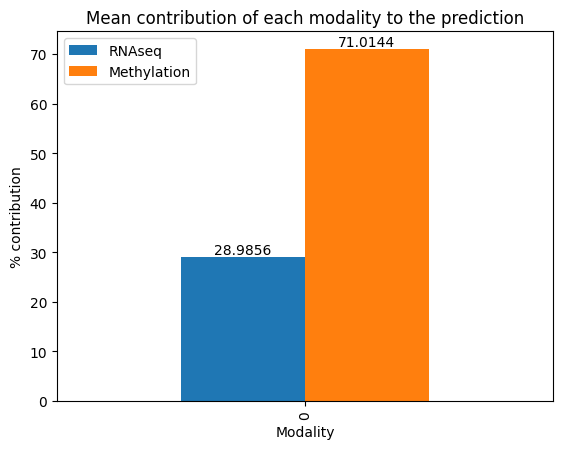

In [333]:
mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
ax = pd.DataFrame([mv_scores]).plot(kind= "bar", ylabel= "% contribution", xlabel= "Modality", title= "Mean contribution of each modality to the prediction")
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
explainer = DeepV2(model, data = list(baselines))
shap_values = explainer.shap_values(list(inputs))

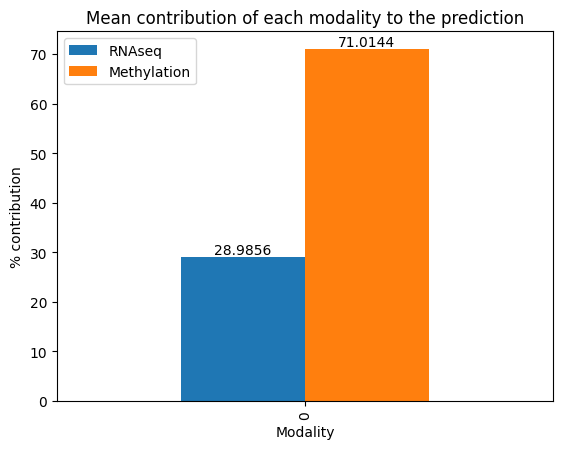

In [552]:
mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
ax = pd.DataFrame([mv_scores]).plot(kind= "bar", ylabel= "% contribution", xlabel= "Modality", title= "Mean contribution of each modality to the prediction")
for container in ax.containers:
    ax.bar_label(container)

In [335]:
mv_scores

,RNAseq,Methylation,clusters
TCGA-2J-AAB6,26.578831,73.421169,1
TCGA-2J-AAB8,28.436470,71.563530,0
TCGA-2J-AAB9,21.872437,78.127563,1
TCGA-2J-AABA,27.985747,72.014253,1
TCGA-2J-AABE,26.947245,73.052755,1
...,...,...,...
TCGA-XD-AAUL,26.396632,73.603368,1
TCGA-XN-A8T3,28.569519,71.430481,1
TCGA-YB-A89D,26.456669,73.543331,1
TCGA-YY-A8LH,26.414621,73.585379,1


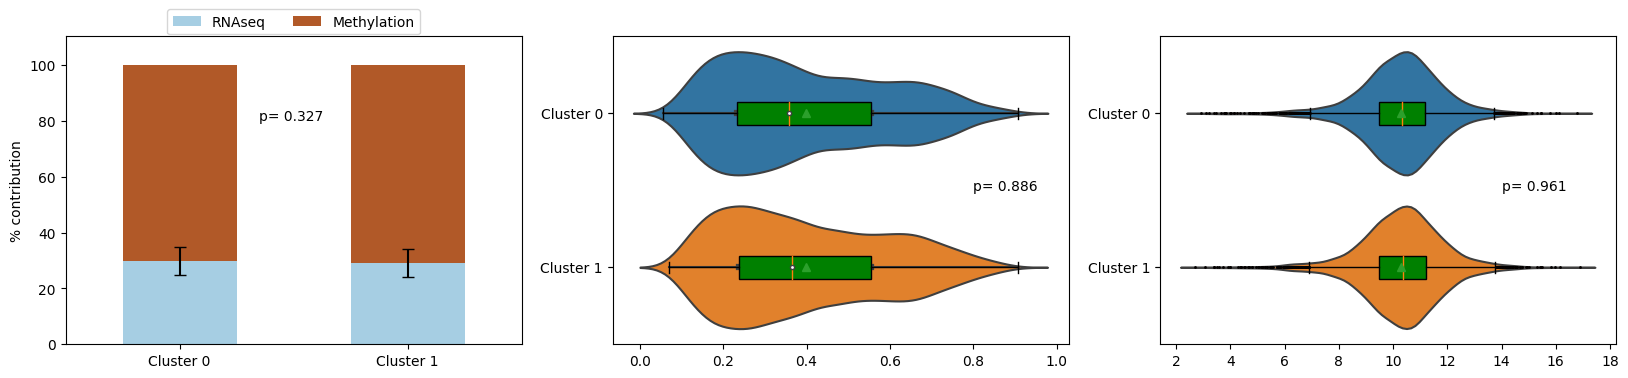

In [336]:
mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
mv_scores = [compute_mv_score(shap_values= shap_values, view_names= views, idx = i) for i in range(len(clusters))]
mv_scores = pd.DataFrame(mv_scores, index= clusters.index)
mv_scores["clusters"] = clusters
fig, axes = plt.subplots(1, 3, figsize= (20, 4))
ax = axes[0]
mv_scores_grouped = mv_scores.replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1").groupby("clusters")
ax = mv_scores_grouped.mean().plot(kind= "bar", ylabel= "% contribution", capsize=4, yerr= mv_scores_grouped.std(), colormap= "Paired", stacked= True, ax= ax, rot= 0)
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.set_xlabel("")
ax.legend(loc= "upper center", ncols= 2, bbox_to_anchor=(0.5, 1.11))
da_for_test= [mv_scores[mv_scores['clusters'] == cl]["Methylation"] for cl in mv_scores['clusters'].unique()]
pval = round(mannwhitneyu(da_for_test[0], da_for_test[1]).pvalue, 5)
ax.text(0.35, 80, f"p= {round(pval, 3)}")

vio_met = pd.DataFrame([methylation_data[transformed_Xs[1].columns].loc[clusters == cl].mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_met, orient= "h", ax = axes[1], palette= colors)
axes[1].boxplot(vio_met, vert=False, positions= [0,1], labels= vio_met.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True)
pval = round(kstest(vio_met["Cluster 0"], vio_met["Cluster 1"]).pvalue, 5)
axes[1].text(0.8, .5, f"p= {round(pval, 3)}")

vio_rna = pd.DataFrame([rnaseq_data[transformed_Xs[0].columns].loc[clusters == cl].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_rna, orient= "h", ax = axes[2], inner=None, palette= colors)
axes[2].boxplot(vio_rna, vert=False, positions= [0,1], labels= vio_rna.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True,
                flierprops={'markersize': 1, 'markerfacecolor': 'r'})
pval = round(kstest(vio_rna["Cluster 0"], vio_rna["Cluster 1"]).pvalue, 5)
axes[2].text(14, .5, f"p= {round(pval, 3)}")

fig.subplots_adjust()
_ = fig.suptitle(None)

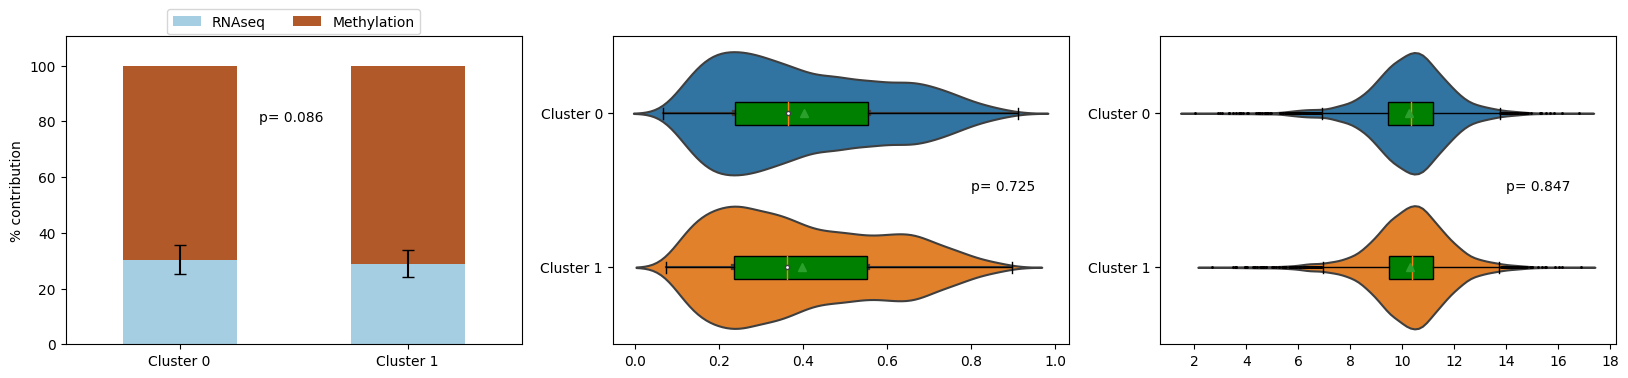

In [193]:
fig, axes = plt.subplots(1, 3, figsize= (20, 4))
ax = axes[0]
mv_scores_grouped = mv_scores.replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1").groupby("clusters")
ax = mv_scores_grouped.mean().plot(kind= "bar", ylabel= "% contribution", capsize=4, yerr= mv_scores_grouped.std(), colormap= "Paired", stacked= True, ax= ax, rot= 0)
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.set_xlabel("")
ax.legend(loc= "upper center", ncols= 2, bbox_to_anchor=(0.5, 1.11))
da_for_test= [mv_scores[mv_scores['clusters'] == cl]["Methylation"] for cl in mv_scores['clusters'].unique()]
pval = round(mannwhitneyu(da_for_test[0], da_for_test[1]).pvalue, 5)
ax.text(0.35, 80, f"p= {round(pval, 3)}")

vio_met = pd.DataFrame([methylation_data[transformed_Xs[1].columns].iloc[clusters == cl].mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_met, orient= "h", ax = axes[1], palette= colors)
axes[1].boxplot(vio_met, vert=False, positions= [0,1], labels= vio_met.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True)
pval = round(kstest(vio_met["Cluster 0"], vio_met["Cluster 1"]).pvalue, 5)
axes[1].text(0.8, .5, f"p= {round(pval, 3)}")

vio_rna = pd.DataFrame([rnaseq_data[transformed_Xs[0].columns].iloc[clusters == cl].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_rna, orient= "h", ax = axes[2], inner=None, palette= colors)
axes[2].boxplot(vio_rna, vert=False, positions= [0,1], labels= vio_rna.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True,
                flierprops={'markersize': 1, 'markerfacecolor': 'r'})
pval = round(kstest(vio_rna["Cluster 0"], vio_rna["Cluster 1"]).pvalue, 5)
axes[2].text(14, .5, f"p= {round(pval, 3)}")

fig.subplots_adjust()
_ = fig.suptitle(None)

In [329]:
mv_scores = [compute_mv_score(shap_values= shap_values, view_names= views, idx = i) for i in range(len(clusters))]
mv_scores = pd.DataFrame(mv_scores, clusters.index)
mv_scores["clusters"] = clusters
ax = mv_scores.sort_values(by= "RNAseq", ascending= True).drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", 
                                                                                         figsize= (30,8), xlabel= "Sample", colormap= "Paired", xticks= [], stacked= True)
ax.xaxis.label.set_fontsize(16)
ax.set_xlabel(ax.get_xlabel(), labelpad=20)
ax.yaxis.label.set_fontsize(16)
ax.yaxis.set_tick_params(labelsize= 16)
_ = ax.legend(loc= "upper center", prop= {"size": 16}, ncols= 2, bbox_to_anchor=(0.5, 1.09))

AttributeError: 'dict' object has no attribute 'sort_values'

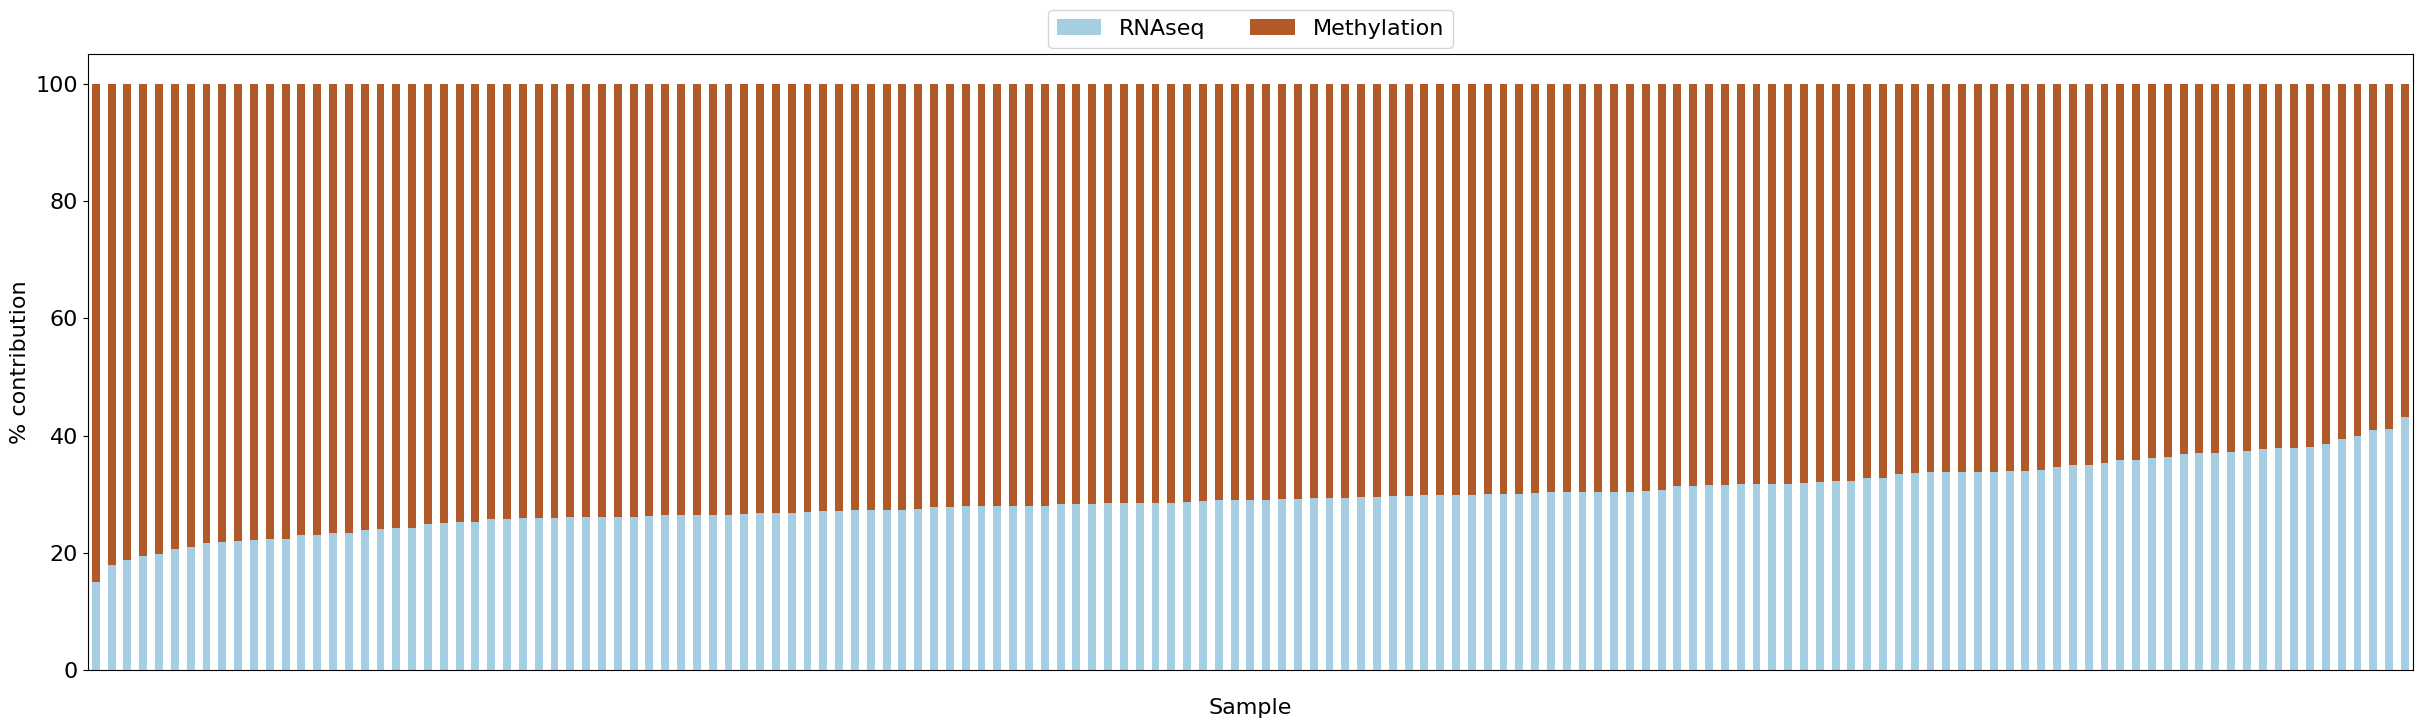

In [197]:
ax = mv_scores.sort_values(by= "RNAseq", ascending= True).drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", 
                                                                                         figsize= (30,8), xlabel= "Sample", colormap= "Paired", xticks= [], stacked= True)
ax.xaxis.label.set_fontsize(16)
ax.set_xlabel(ax.get_xlabel(), labelpad=20)
ax.yaxis.label.set_fontsize(16)
ax.yaxis.set_tick_params(labelsize= 16)
_ = ax.legend(loc= "upper center", prop= {"size": 16}, ncols= 2, bbox_to_anchor=(0.5, 1.09))

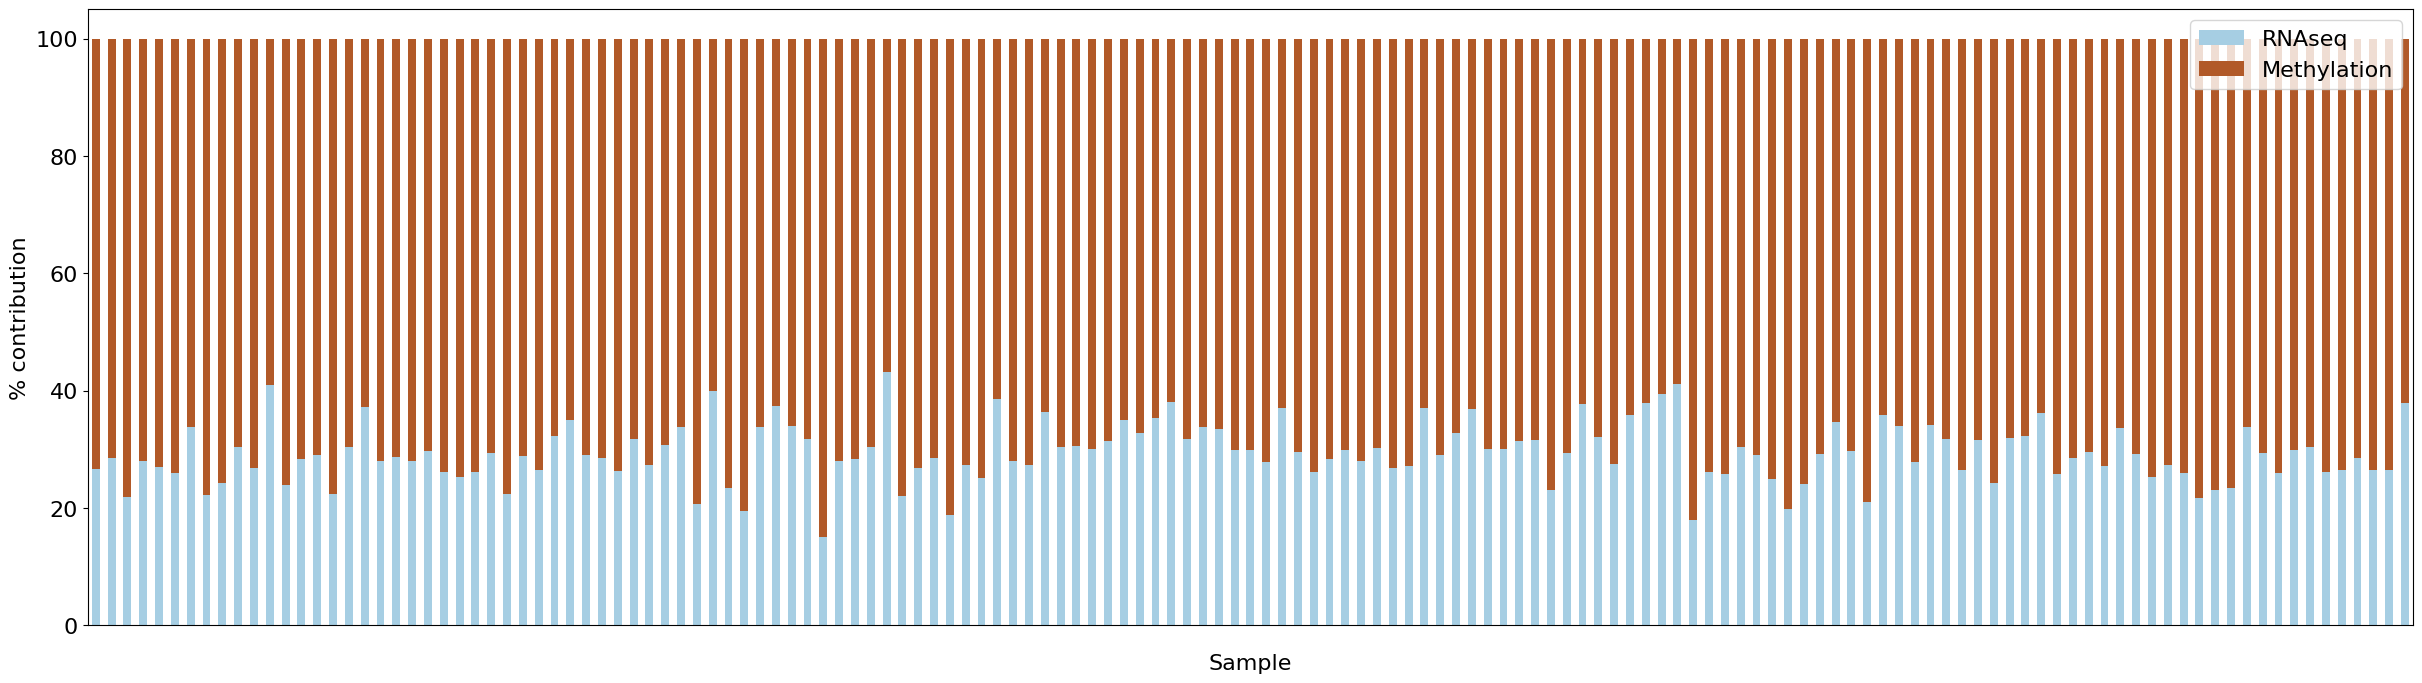

In [903]:
ax = mv_scores.drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", figsize= (30,8), xlabel= "Sample", colormap= "Paired", xticks= [], stacked= True)
ax.xaxis.label.set_fontsize(16)
ax.set_xlabel(ax.get_xlabel(), labelpad=20)
ax.yaxis.label.set_fontsize(16)
ax.yaxis.set_tick_params(labelsize= 16)
_ = ax.legend(loc= "upper right", prop= {"size": 16})

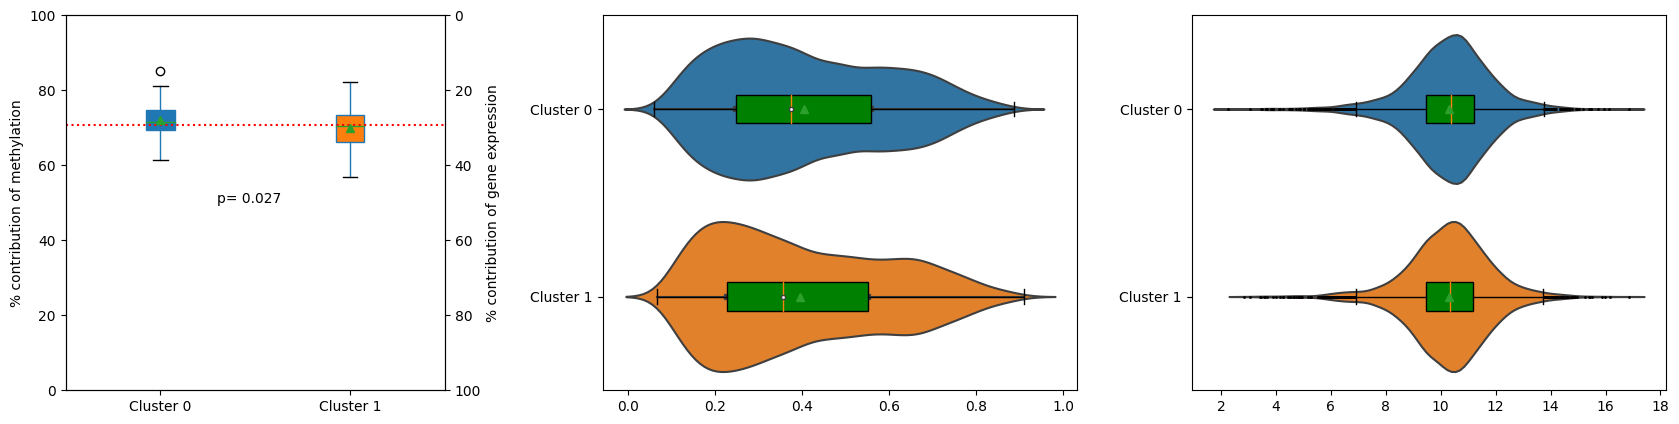

In [835]:
fig, axes = plt.subplots(1, 5, figsize= (20, 5), gridspec_kw={'width_ratios': [0.8, 0.1, 1, 0.01, 1]})
axes[1].set_visible(False)
axes[3].set_visible(False)
ax = axes[0]
props = mv_scores.replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1").boxplot(column= "Methylation", 
                                                                                                      by= 'clusters', figsize= (10, 4),
                                                                                                      grid= False, ylabel= "% contribution of methylation",
                                                                                                      showmeans= True, ax= ax, patch_artist=True, return_type='dict')
ax.set_xlabel("")
ax.set_title("")
ax.axhline(mv_scores["Methylation"].mean(), c= "red", linestyle= ":")
colors = ['#1f77b4', '#ff7f0e']
for i,box in enumerate(props[0]['boxes']):
    box.set_facecolor(colors[i])
ax2 = ax.twinx()
pval = round(kruskal(*[mv_scores[mv_scores['clusters'] == cl]["Methylation"] for cl in mv_scores['clusters'].unique()]).pvalue, 5)
ax.set_ylim(0,100)
ax2.set_ylim(100,0)
ax2.set_ylabel("% contribution of gene expression")
_ = ax.text(1.3, 50, f"p= {round(pval, 3)}")

vio_met = pd.DataFrame([methylation_data[transformed_Xs[1].columns].iloc[clusters == cl].mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_met, orient= "h", ax = axes[2], palette= colors)
axes[2].boxplot(vio_met, vert=False, positions= [0,1], labels= vio_met.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True)

vio_rna = pd.DataFrame([rnaseq_data[transformed_Xs[0].columns].iloc[clusters == cl].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_rna, orient= "h", ax = axes[4], inner=None, palette= colors)
axes[4].boxplot(vio_rna, vert=False, positions= [0,1], labels= vio_rna.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True,
                flierprops={'markersize': 1, 'markerfacecolor': 'r'})

fig.subplots_adjust()
_ = fig.suptitle(None)

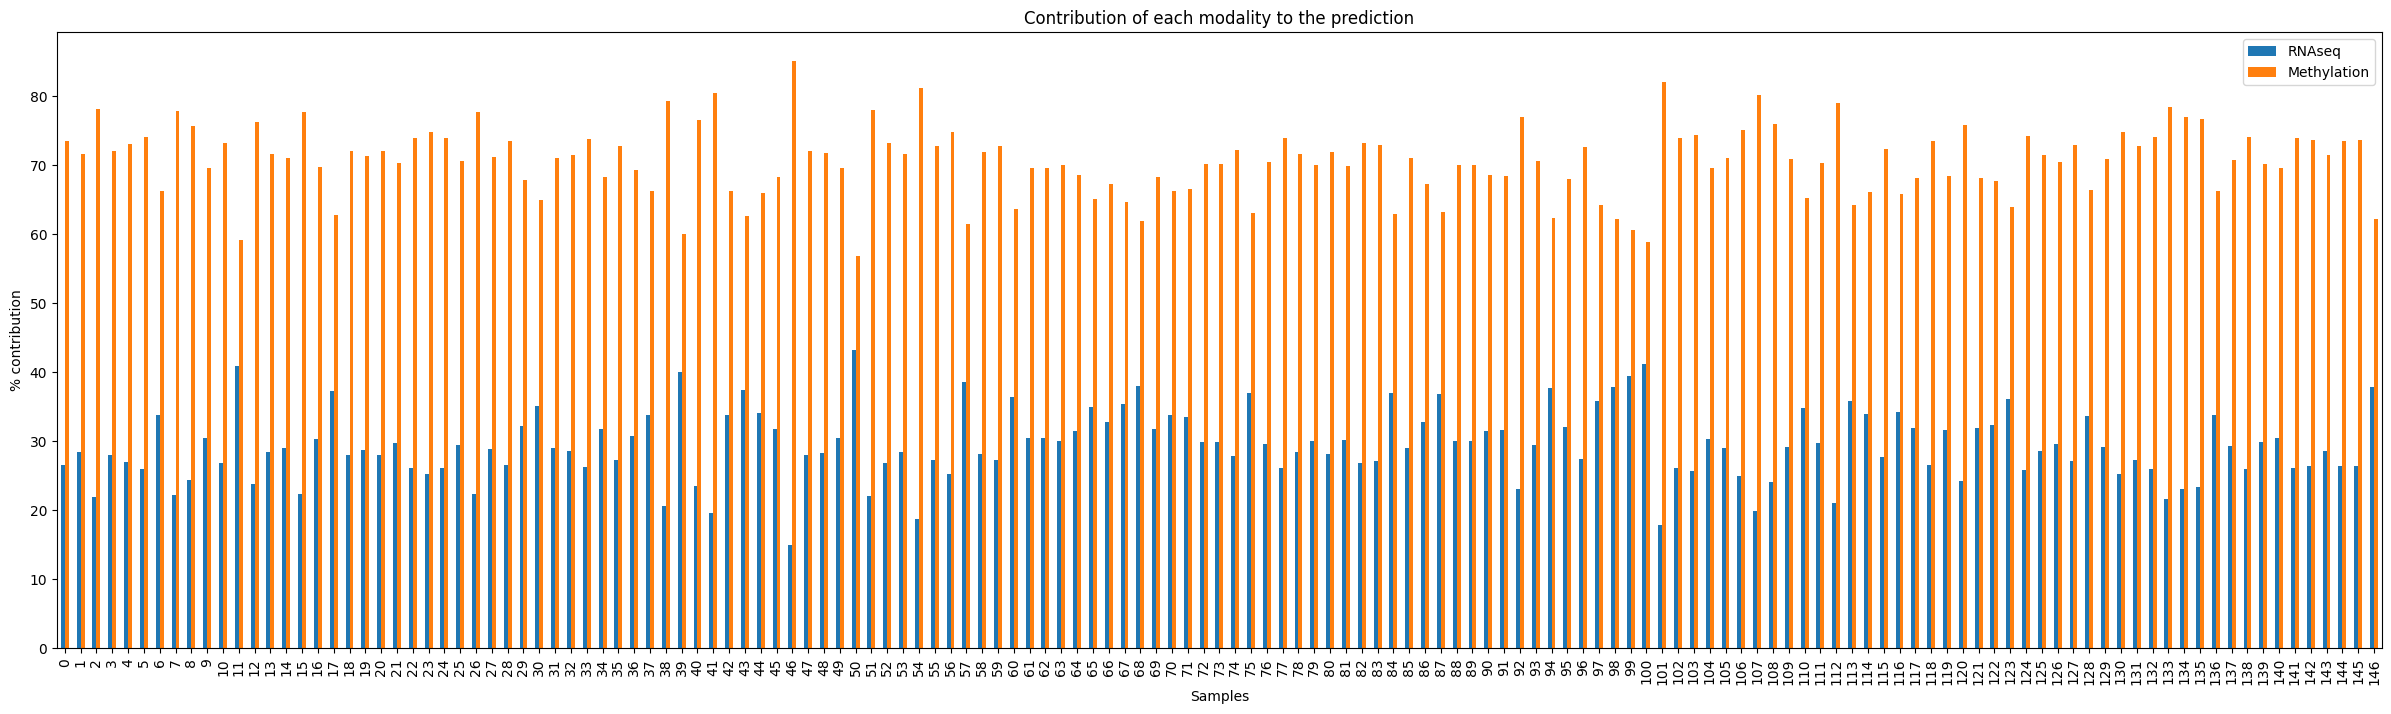

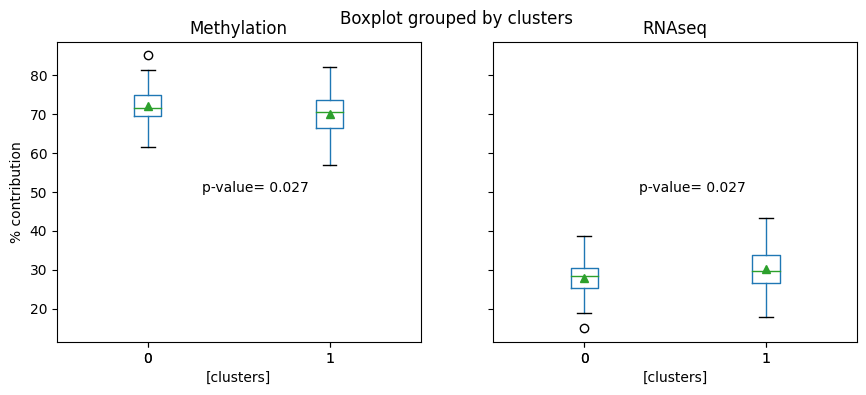

In [553]:
mv_scores = [compute_mv_score(shap_values= shap_values, view_names= views, idx = i) for i in range(len(clusters))]
mv_scores = pd.DataFrame(mv_scores)
mv_scores["clusters"] = clusters
ax = mv_scores.drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", figsize= (30,8), xlabel= "Samples", 
                                              title= "Contribution of each modality to the prediction")
axes = mv_scores.boxplot(by= 'clusters', figsize= (10, 4), grid= False, ylabel= "% contribution", showmeans= True)
for ax,view in zip(axes, views):
    pval = round(kruskal(*[mv_scores[mv_scores['clusters'] == cl][view] for cl in mv_scores['clusters'].unique()]).pvalue, 5)
    _ = ax.text(1.3, 50, f"p-value= {round(pval, 3)}")

In [ ]:
ig = IntegratedGradients(model)
ig.gradient_func = compute_gradients
ig_nt = NoiseTunnel(ig)
gs = GradientShap(model)
gs.gradient_func = compute_gradients
fa = FeatureAblationV2(model)

ig_attr_test = ig.attribute(inputs, target = target)
ig_nt_attr_test = ig_nt.attribute(inputs, target = target)
gs_attr_test = gs.attribute(inputs, inputs, target = target)
fa_attr_test = fa.attribute(inputs, target = target)

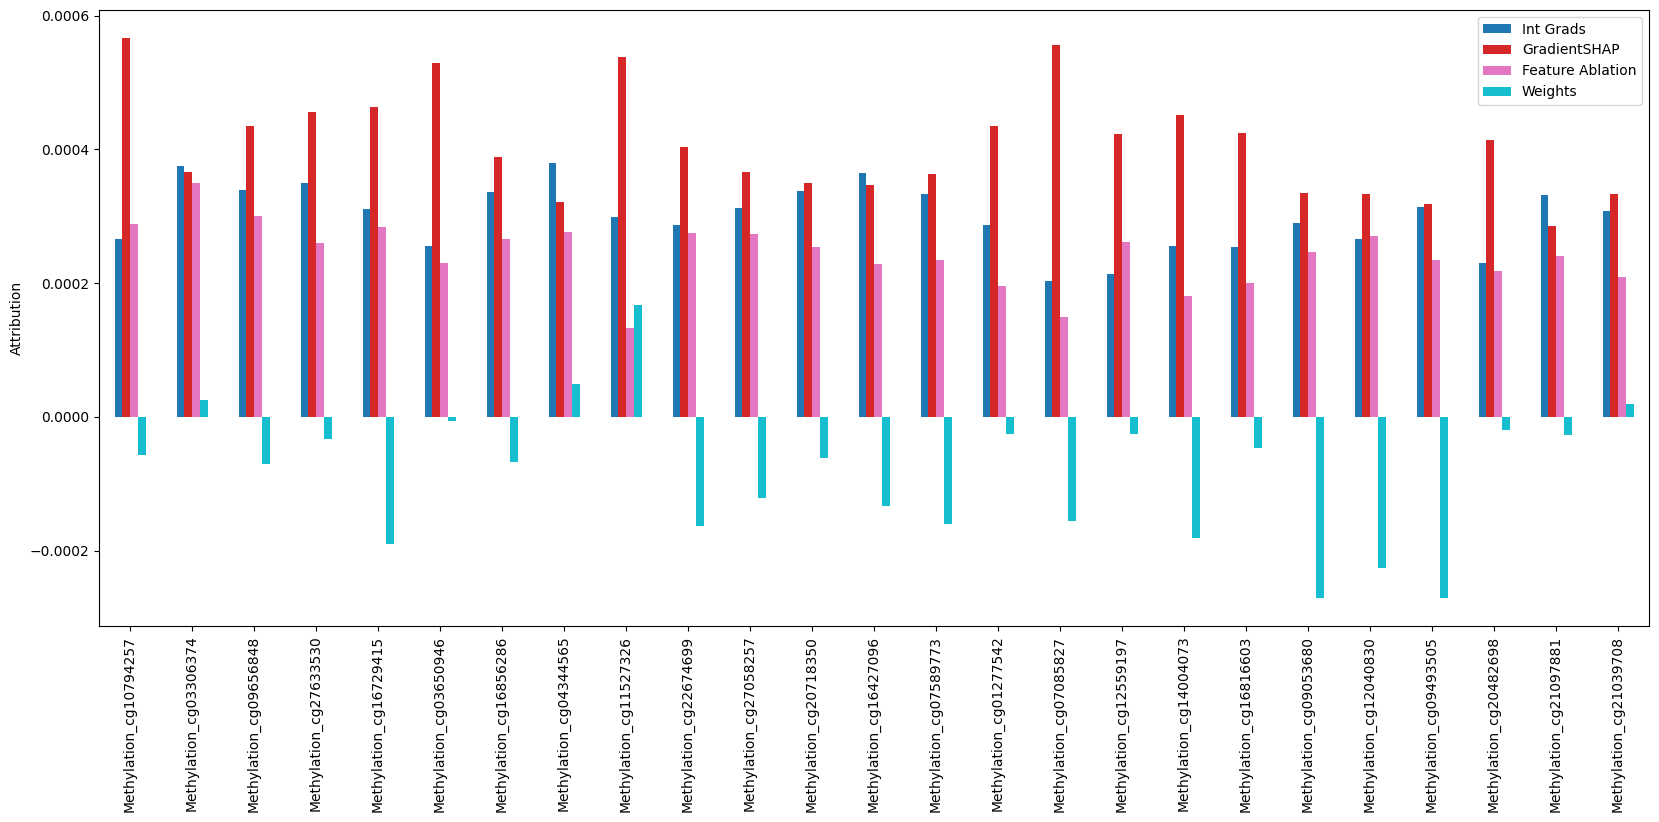

In [850]:
df, most_important_features = compute_most_important_features_based_attribution(features=features, algorithms=[ig_attr_test, gs_attr_test, fa_attr_test],
                                                                                names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'], top_n = 25)
weights = torch.cat([eval(f"model.autoencoder.encoder_{0}")[1][0].weight for enc in range(len(views))], dim= 1).mean(0).detach().numpy()
df["Weights"] = weights / np.linalg.norm(weights, ord=1)
df = df.loc[most_important_features]
_ = df.plot(kind= "bar", figsize = (20, 8), ylabel= "Attribution", colormap= "tab10")

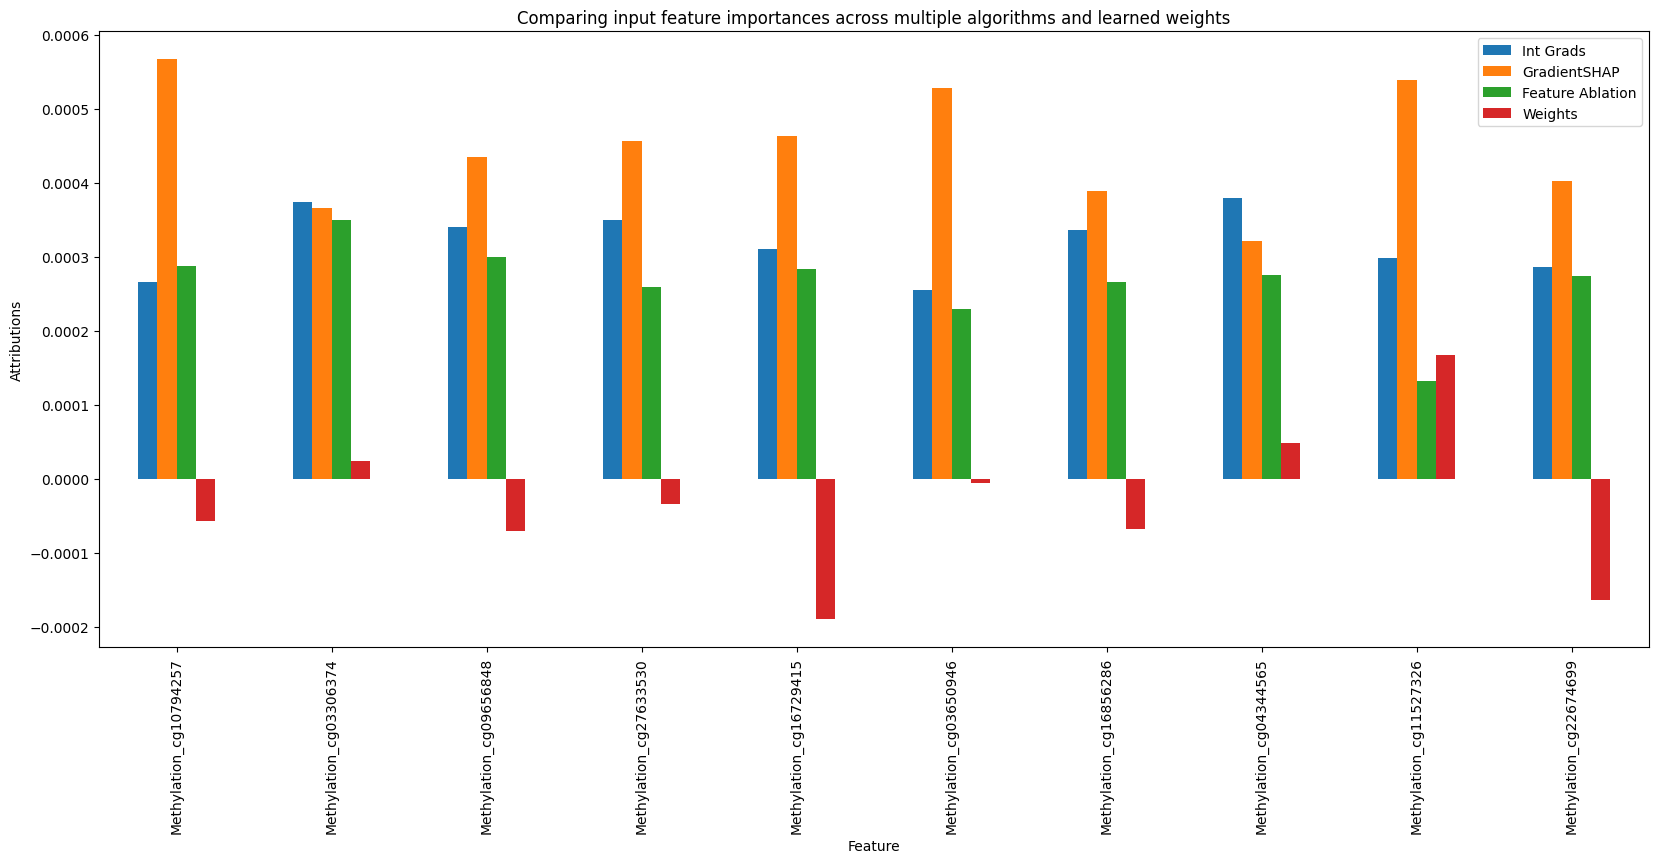

In [543]:
plot_attribution_algorithm_comparison(features=features, algorithms= [ig_attr_test, gs_attr_test, fa_attr_test],
                                      names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'],
                                      weights= [eval(f"model.autoencoder.encoder_{0}")[1][0].weight for enc in range(len(views))],
                                      top_n = 10, figsize = (20, 8))

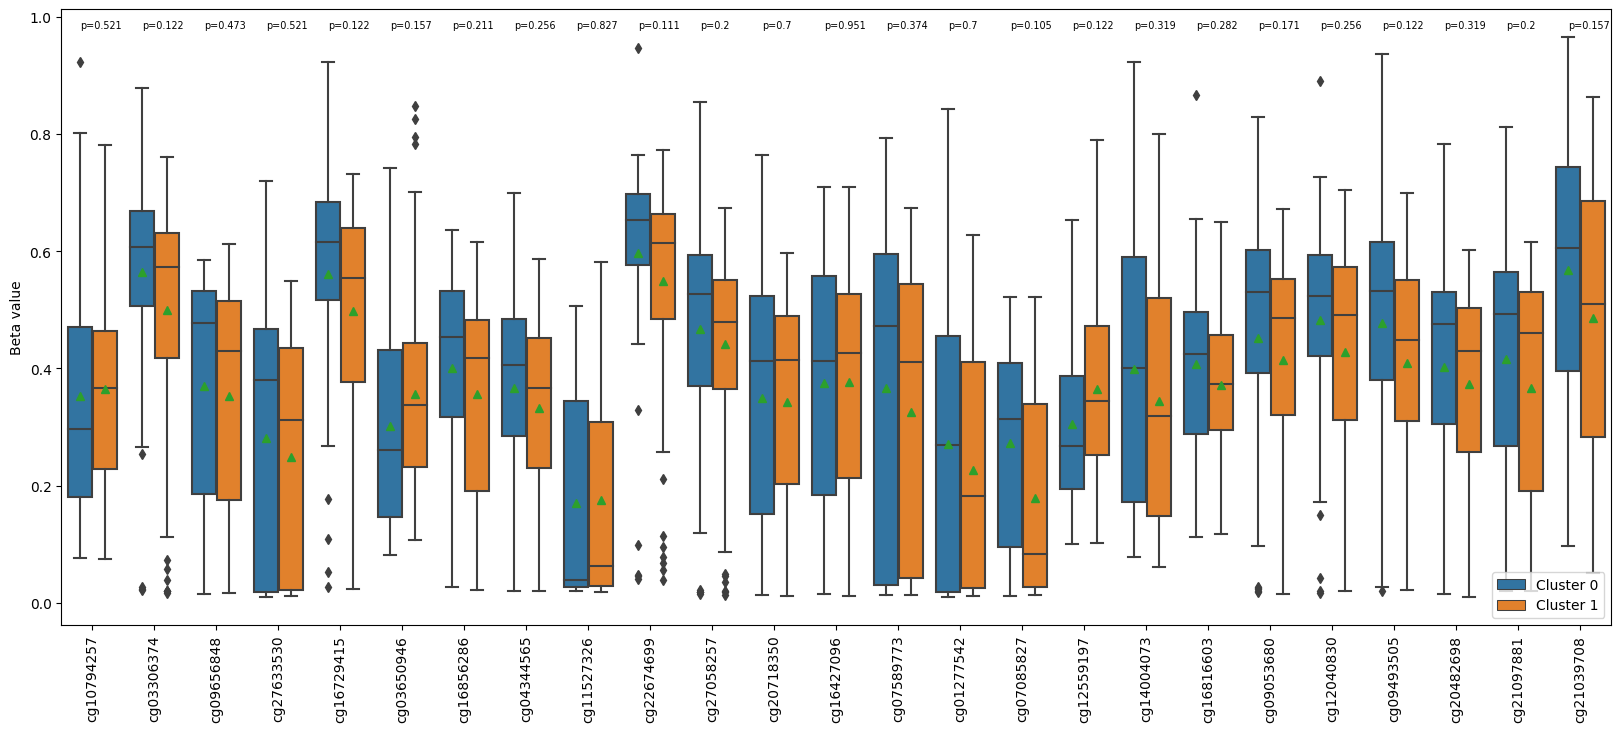

In [837]:
df = pd.concat(Xs, axis= 1)
_, most_important_features = compute_most_important_features_based_attribution(features=features, algorithms= [ig_attr_test, gs_attr_test, fa_attr_test],
                                                                               names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'], top_n = 25)
most_important_features = [i.split("_")[-1] for i in most_important_features]
df = df[most_important_features]
df["clusters"] = clusters
df = df.fillna(df.mean())

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters').replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1"),
                 x="variable", y="value", hue="clusters", hue_order= ["Cluster 0", "Cluster 1"], showmeans= True, palette= colors)
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "", loc= "lower right")
ax.set_xlabel("")
ax.set_ylabel("Beta value")
ax.set_title("")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, .98, f"p={pvals[xtick]}", size='x-small', color= c.iloc[xtick])

In [546]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

Accuracy score = 0.65


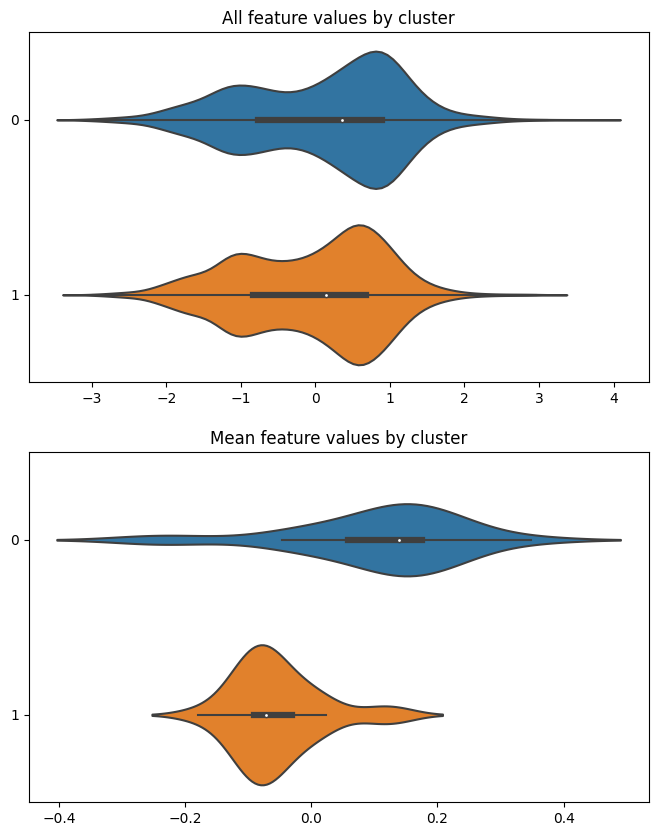

In [547]:
df = pd.concat(transformed_Xs, axis= 1)
_, most_important_features = compute_most_important_features_based_attribution(features=features, algorithms= [ig_attr_test, gs_attr_test, fa_attr_test],
                                                                               names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'], top_n = 25)
most_important_features = [i.split("_")[-1] for i in most_important_features]
df = df[most_important_features]
df["clusters"] = clusters

fig, axes = plt.subplots(2, 1, figsize= (8, 10))

ax = axes[0]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h", ax = ax)
ax.set_title("All feature values by cluster")

ax = axes[1]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h",  ax = ax)
_ = ax.set_title("Mean feature values by cluster")

In [231]:
pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T

,0,1
0,0.362924,0.359457
1,0.528477,0.517532
2,0.350213,0.362181
3,0.261832,0.258607
4,0.495373,0.530894
5,0.337870,0.337595
6,0.382607,0.366191
7,0.340345,0.346945
8,0.180809,0.169627
9,0.549912,0.573259


In [260]:
df

,cg10794257,cg03306374,cg09656848,cg27633530,cg16729415,cg03650946,cg16856286,cg04344565,cg11527326,cg22674699,...,cg07085827,cg12559197,cg14004073,cg16816603,cg09053680,cg12040830,cg09493505,cg20482698,cg21097881,cg21039708
clusters,,,,,,,,,,,,,,,,,,,,,
Cluster 0,0.362924,0.528477,0.350213,0.261832,0.495373,0.337870,0.382607,0.340345,0.180809,0.549912,...,0.233515,0.351234,0.380961,0.377144,0.419357,0.464576,0.429151,0.396861,0.389616,0.505611
Cluster 1,0.359457,0.517532,0.362181,0.258607,0.530894,0.337595,0.366191,0.346945,0.169627,0.573259,...,0.199692,0.339972,0.353629,0.386678,0.430606,0.437957,0.434273,0.375936,0.380064,0.516969


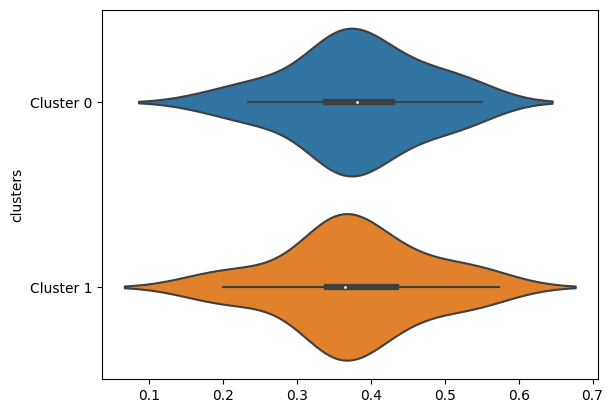

In [266]:
most_important_features = ["cg10794257", "cg03306374", "cg09656848", "cg27633530", "cg16729415", "cg03650946", "cg16856286", "cg04344565", "cg11527326",
                           "cg22674699", "cg27058257", "cg20718350", "cg16427096", "cg07589773", "cg01277542", "cg07085827", "cg12559197", "cg14004073",
                           "cg16816603", "cg09053680", "cg12040830", "cg09493505", "cg20482698", "cg21097881", "cg21039708"]

df = pd.concat(Xs, axis= 1)[most_important_features]
df["clusters"] = pd.Series(clusters).replace(0, "Cluster 0").replace(1, "Cluster 1").values
ax = sns.violinplot(data= df.groupby("clusters").mean().T, orient= "h")

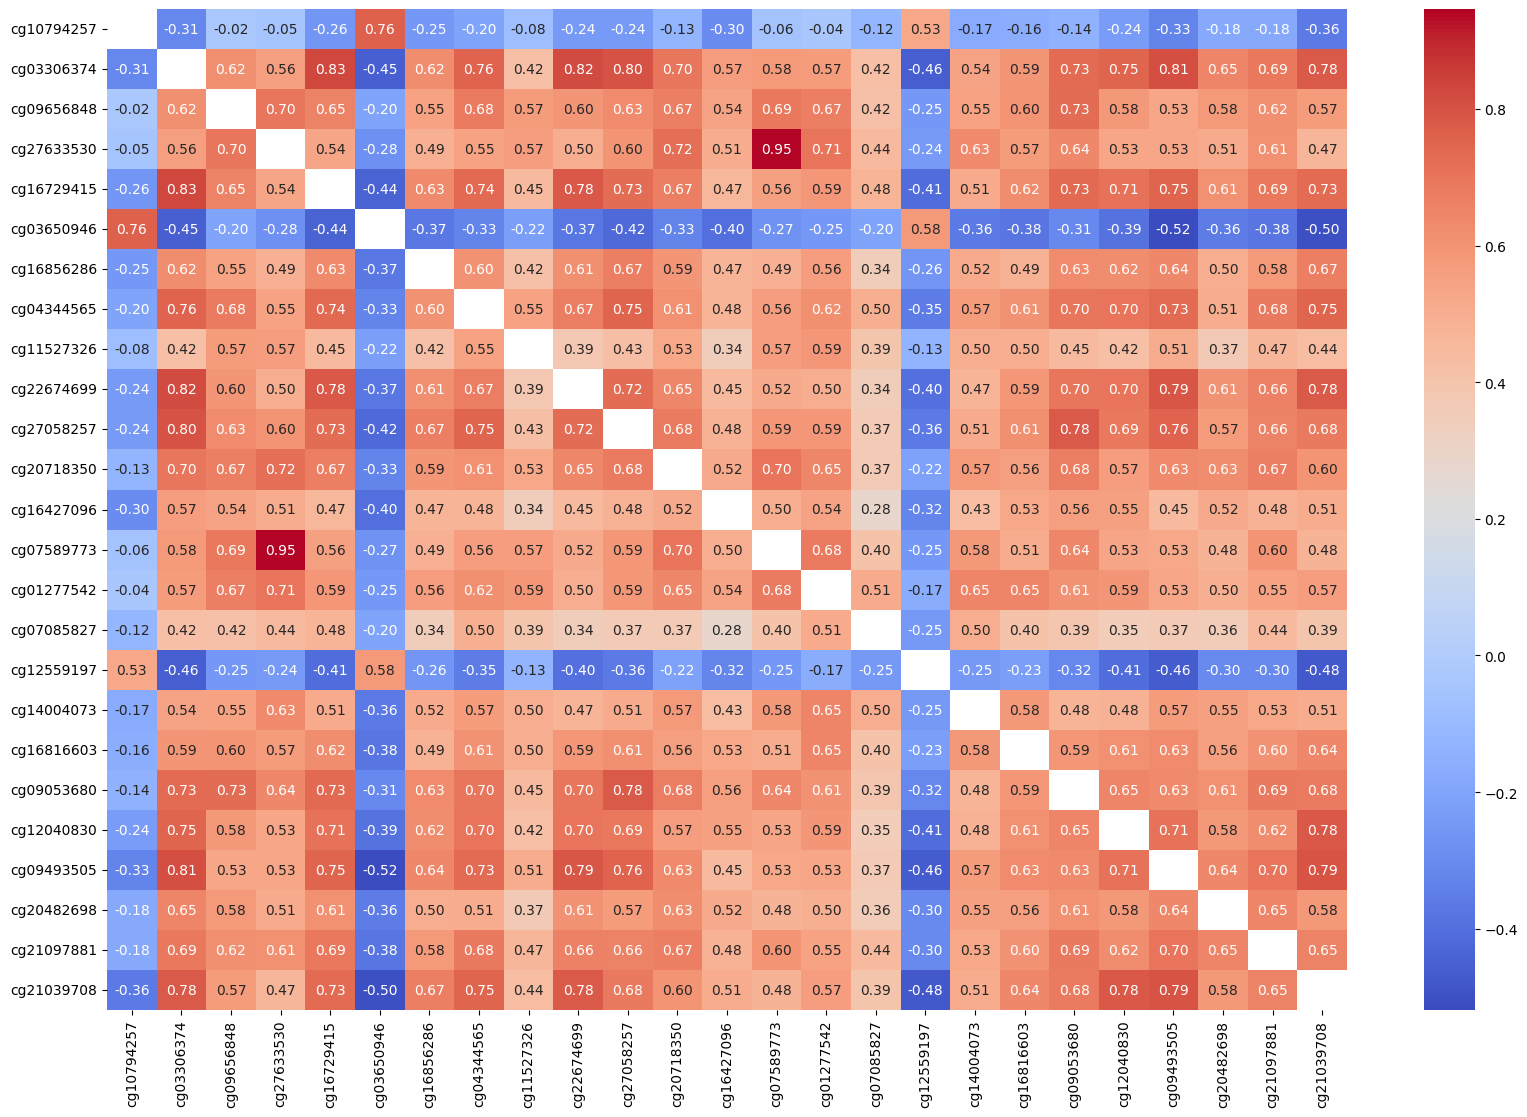

In [294]:
ax.figure

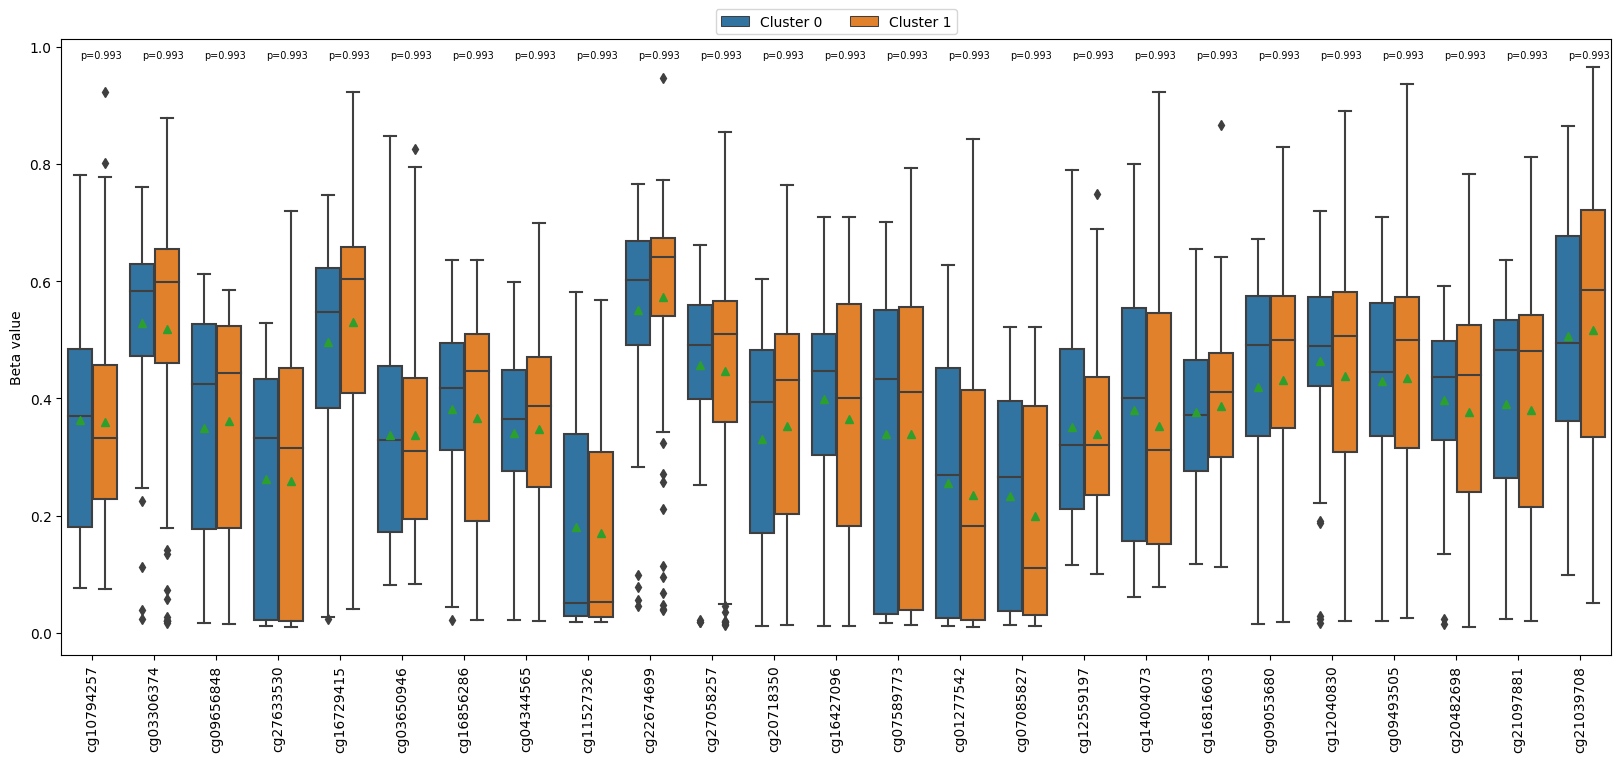

In [314]:
df = pd.concat(Xs, axis= 1)
df = df[most_important_features]
df["clusters"] = clusters
df = df.fillna(df.mean())

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters').replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1"),
                 x="variable", y="value", hue="clusters", hue_order= ["Cluster 0", "Cluster 1"], showmeans= True, palette= colors)
ax.tick_params(axis='x', rotation=90)
ax.legend(loc= "upper center", ncols= 2, bbox_to_anchor=(0.5, 1.06))

# ax.legend(title= "", loc= "lower right")
ax.set_xlabel("")
ax.set_ylabel("Beta value")
ax.set_title("")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, .98, f"p={pvals[xtick]}", size='x-small', color= c.iloc[xtick])

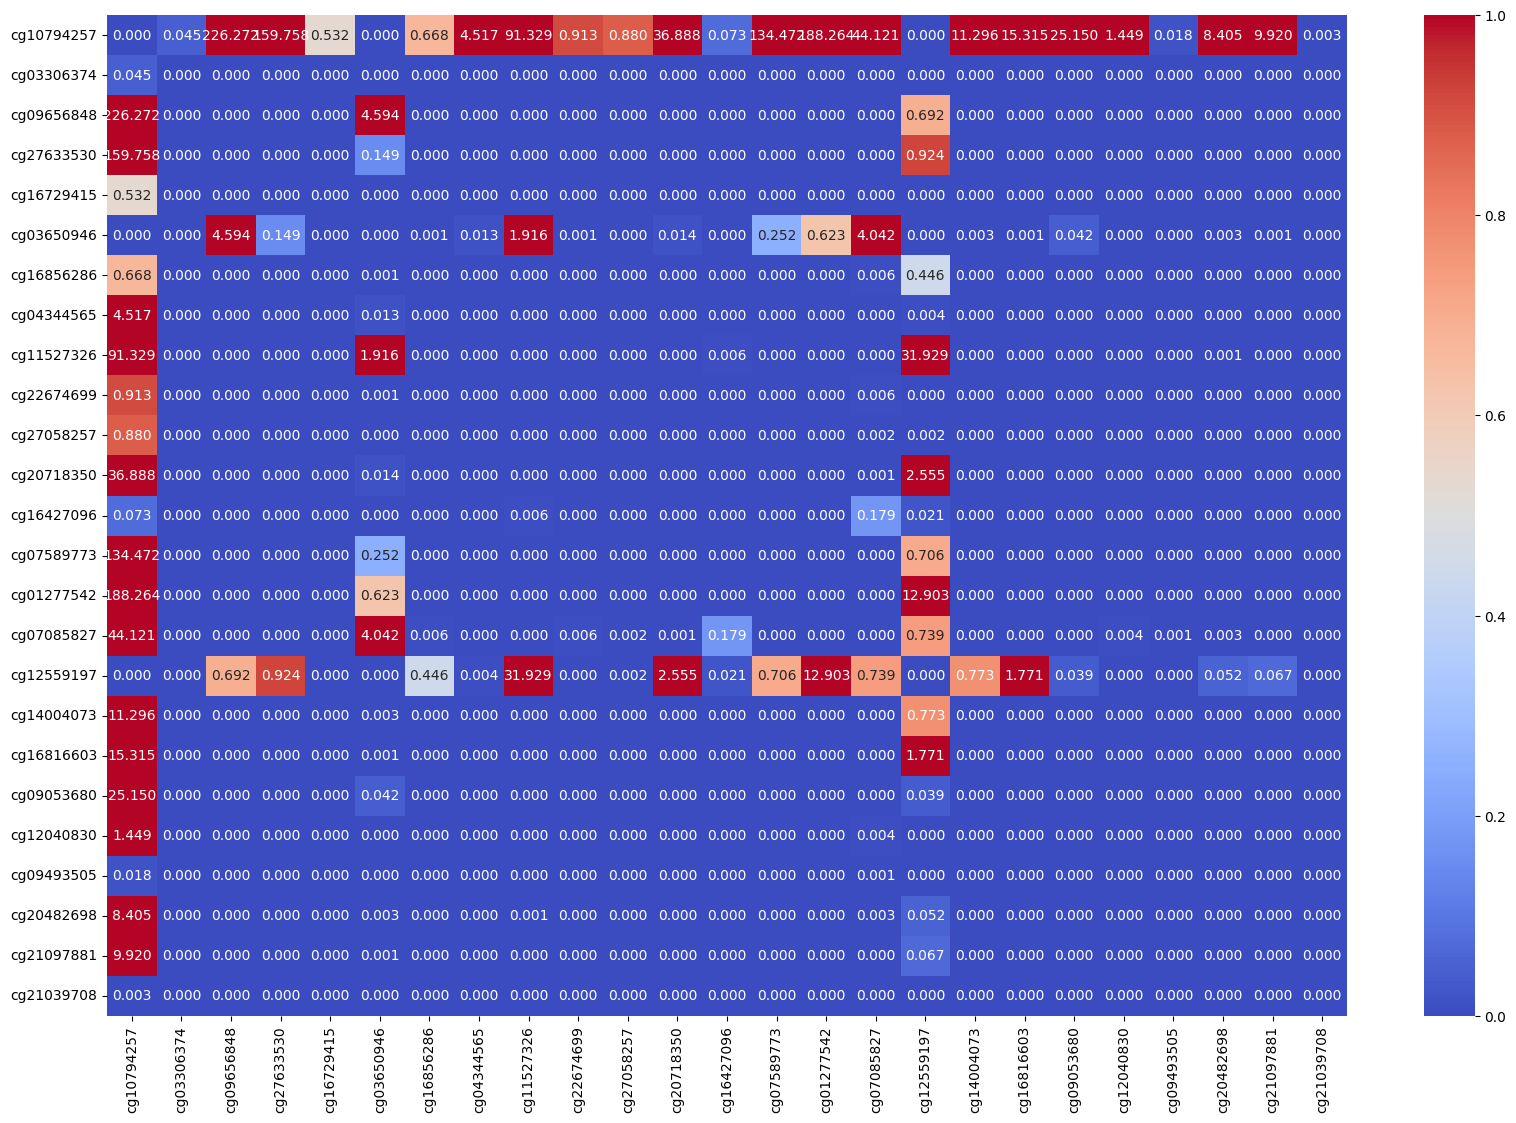

In [403]:
from scipy.stats import pearsonr
plt.figure(figsize=(20,13))
corr = df.drop(columns= "clusters").corr(lambda x,y: pearsonr(x,y)[1])
corr = corr.replace(1, 0) * (corr.size/2 - len(corr))
ax = sns.heatmap(corr,annot=True, cmap= "coolwarm", fmt= ".3f", vmax=1)

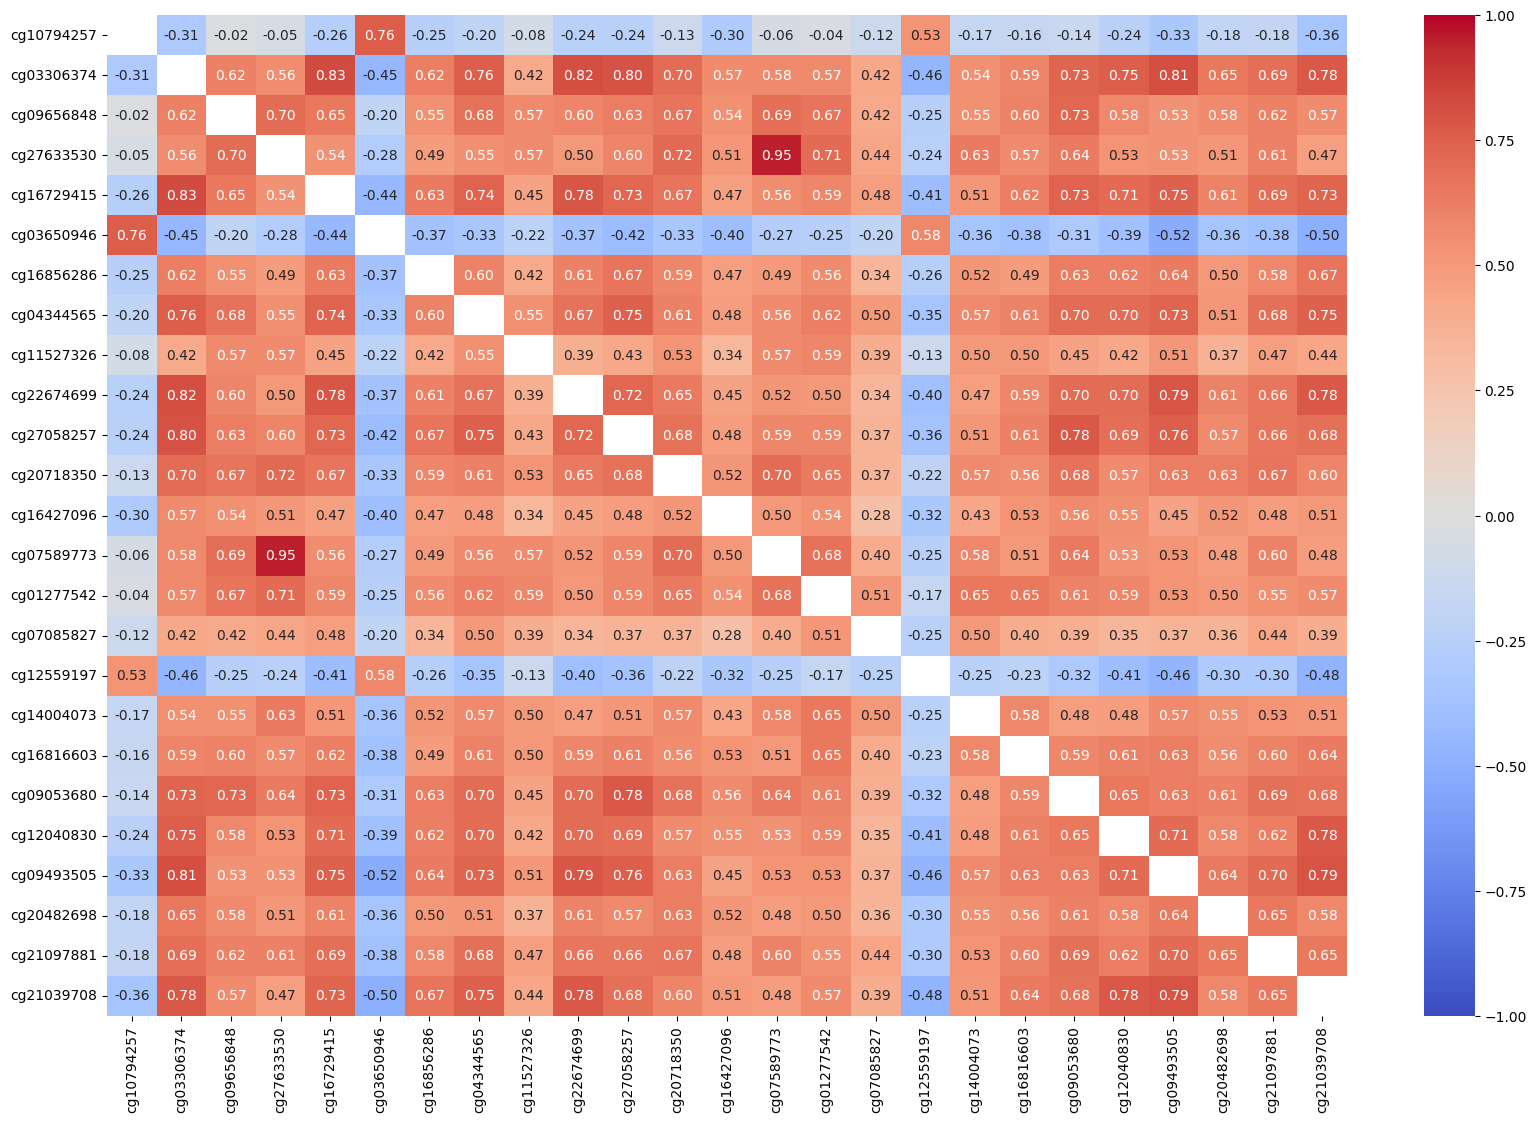

In [302]:
plt.figure(figsize=(20,13))
corr = df.drop(columns= "clusters").corr().replace(1, np.nan)
ax = sns.heatmap(corr,annot=True, cmap= "coolwarm", fmt= ".2f", vmin= -1, vmax= 1)
# ax.figure.colorbar(ax.collections[0]).set_clim(-1,1)

In [ ]:
ax = axes[1]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h",  ax = ax)
_ = ax.set_title("Mean feature values by cluster")

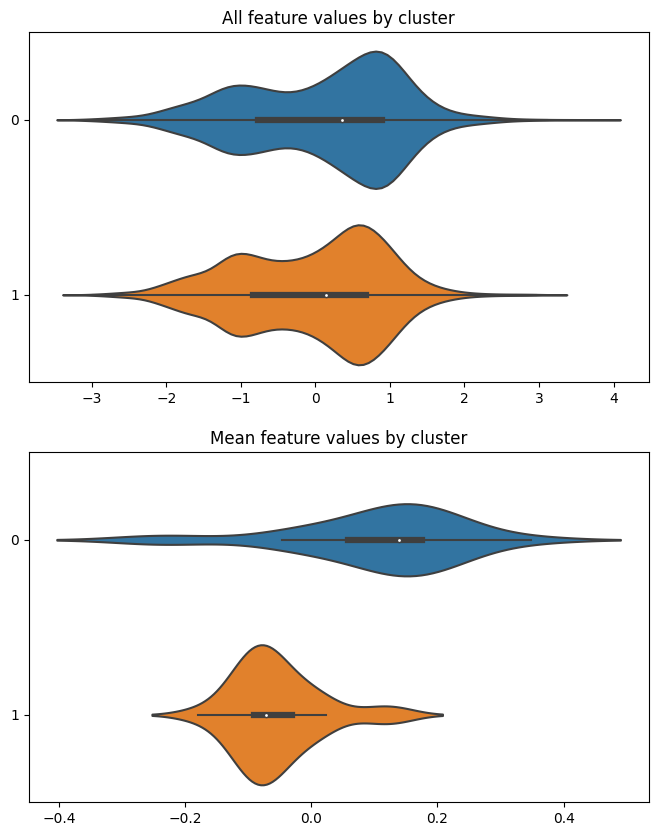

In [548]:
fig, axes = plt.subplots(2, 1, figsize= (8, 10))

ax = axes[0]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h", ax = ax)
ax.set_title("All feature values by cluster")

ax = axes[1]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h",  ax = ax)
_ = ax.set_title("Mean feature values by cluster")

In [ ]:
layer = eval(f"model.autoencoder.encoder_{model.autoencoder.views}")
lc = LayerConductance(model, layer[1], device_ids = model.cluster_centers_.device)
lc._attribute = types.MethodType(layerconductance._attribute, lc)

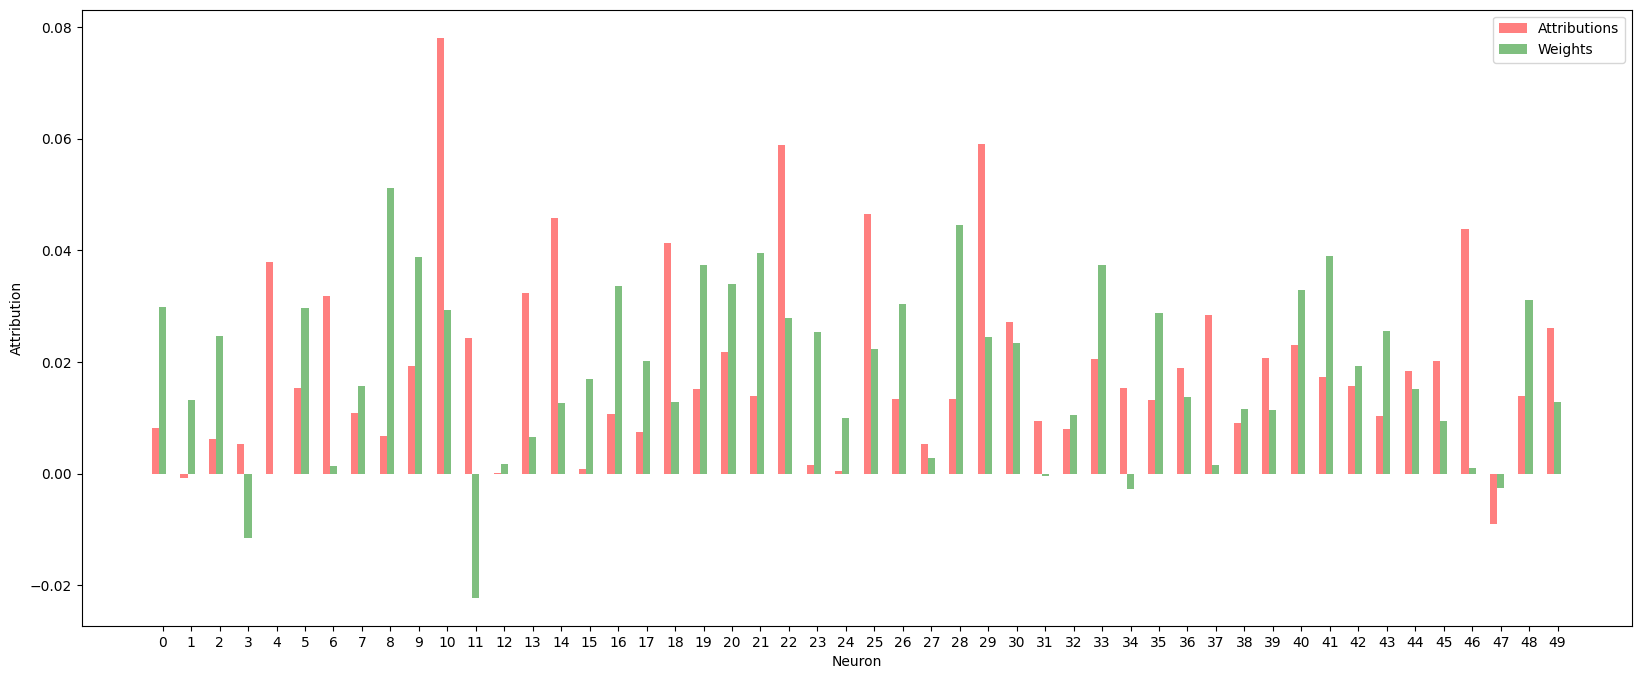

In [851]:
def plot_comparison_attributions_weights_(lc_attr, weights, layer_name = "embedding", figsize=(15, 8)):
    plt.figure(figsize=figsize)
    x_axis_data = np.arange(lc_attr.shape[1])
    y_axis_lc_attr = lc_attr.mean(0)
    y_axis_lc_attr = y_axis_lc_attr / np.linalg.norm(y_axis_lc_attr, ord=1)
    
    y_axis_layer_weight = weights.mean(1)
    y_axis_layer_weight = y_axis_layer_weight / np.linalg.norm(y_axis_layer_weight, ord=1)
    width = 0.25
    legends = ['Attributions','Weights']
    ax = plt.subplot()
    ax.bar(x_axis_data + width, y_axis_lc_attr, width, align='center', alpha=0.5, color='red')
    ax.bar(x_axis_data + 2 * width, y_axis_layer_weight, width, align='center', alpha=0.5, color='green')
    ax.set_ylabel("Attribution")
    ax.set_xlabel("Neuron")
    plt.legend(legends)
    ax.autoscale_view()
    if len(y_axis_layer_weight) <= 100:
        x_axis_labels = list(range(len(y_axis_layer_weight)))
        ax.set_xticks(x_axis_data + 0.5)
        ax.set_xticklabels(x_axis_labels)
    plt.show()


plot_comparison_attributions_weights_(lc_attr = lc_attr_test.detach().numpy(), weights = layer[0].weight.detach().numpy(), layer_name = "embedding", figsize=(20, 8))

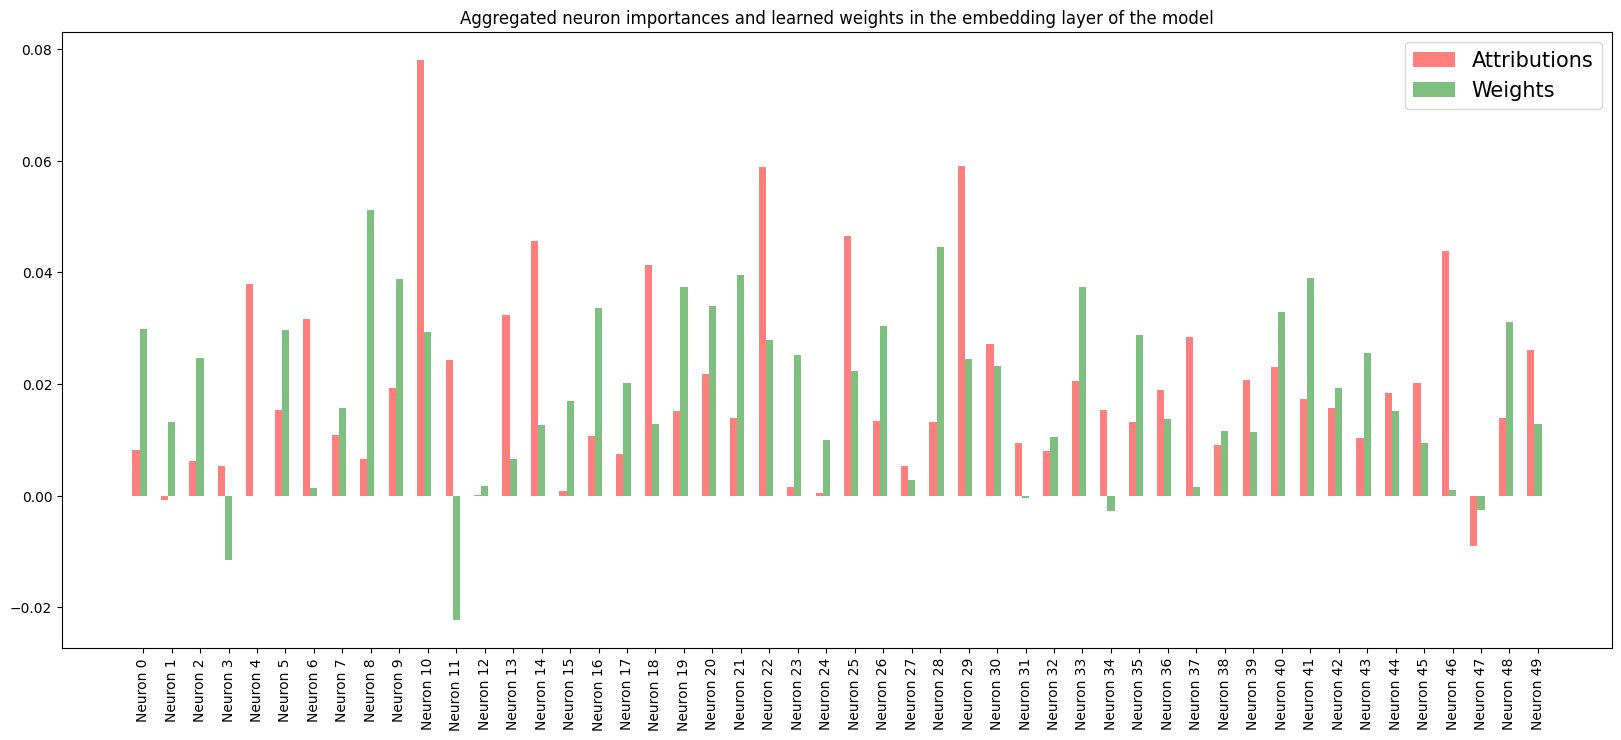

In [549]:
lc_attr_test = lc.attribute(inputs = inputs, baselines=baselines, target = target)
plot_comparison_attributions_weights(lc_attr = lc_attr_test.detach().numpy(), weights = layer[0].weight.detach().numpy(), layer_name = "embedding", figsize=(20, 8))

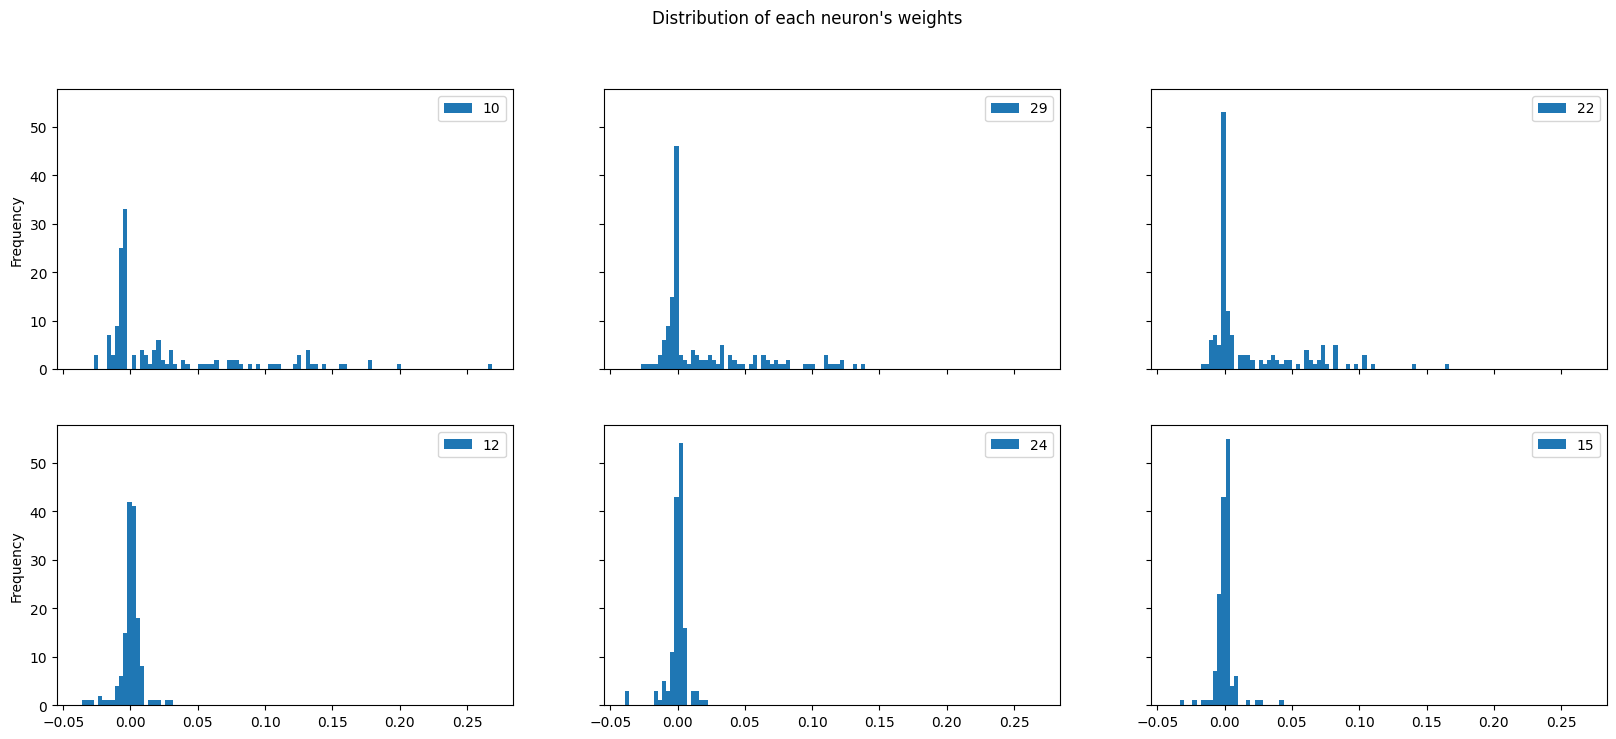

In [550]:
cond_vals = lc_attr_test.detach().numpy()
sorted_neurons = np.abs(cond_vals.mean(0)).argsort()[::-1].tolist()
plot_attribution_distribution(cond_vals = cond_vals, figsize = (20, 8), strong_features = sorted_neurons[:3], weak_features = sorted_neurons[-3:][::-1])

In [ ]:
neuron_cond = NeuronConductance(model, layer[1], device_ids = model.cluster_centers_.device)
neuron_cond._attribute = types.MethodType(neuronconductance._attribute, neuron_cond)

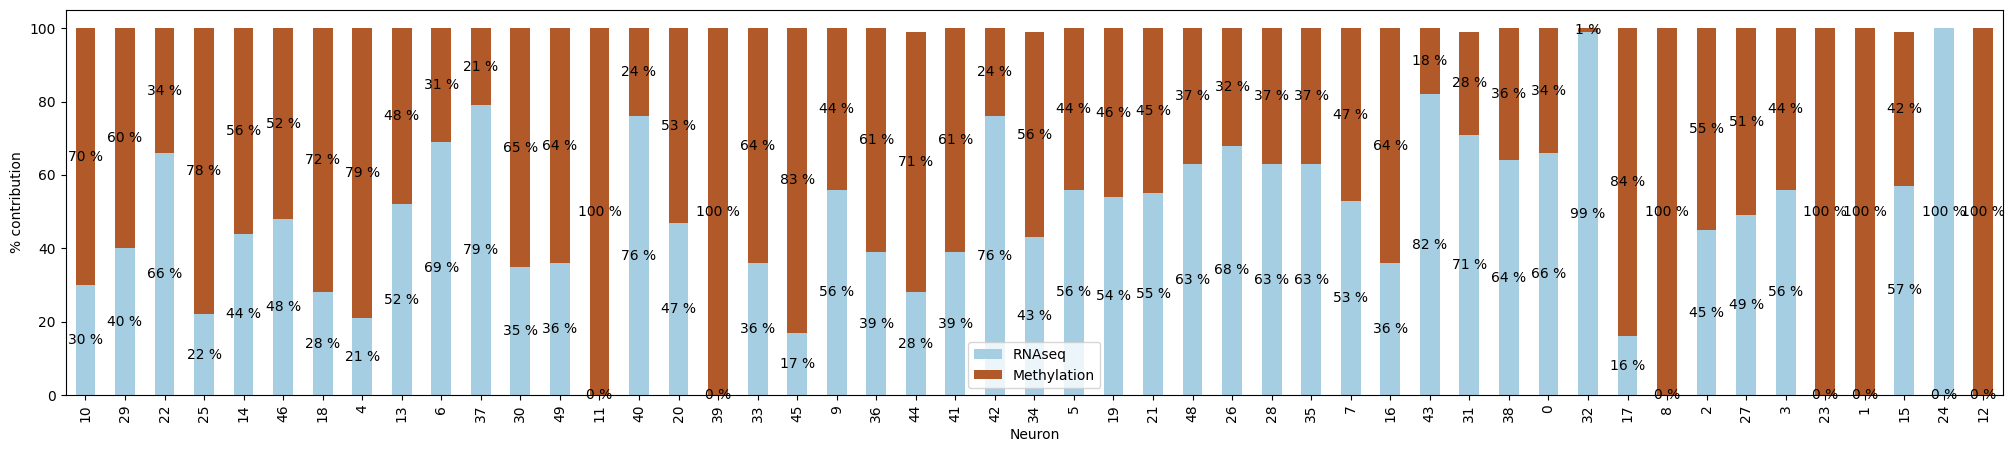

In [863]:
df = pd.DataFrame()

for neuron_selector in sorted_neurons:
    neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
    importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
    most_important_features = features.to_frame("feature")
    most_important_features["importance"] = importances
    for view in views:
        df.loc[neuron_selector, view] = most_important_features[most_important_features["feature"].str.startswith(view)]["importance"].sum()

df[df < 0] = 0
df = (df.T / df.sum(1)).T
df = df.dropna()
df = df.round(2) * 100
df = df.astype(int)

ax = df.plot(kind='bar', stacked=True, figsize= (25, 5), xlabel= "Neuron", ylabel= "% contribution", colormap= "Paired")
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

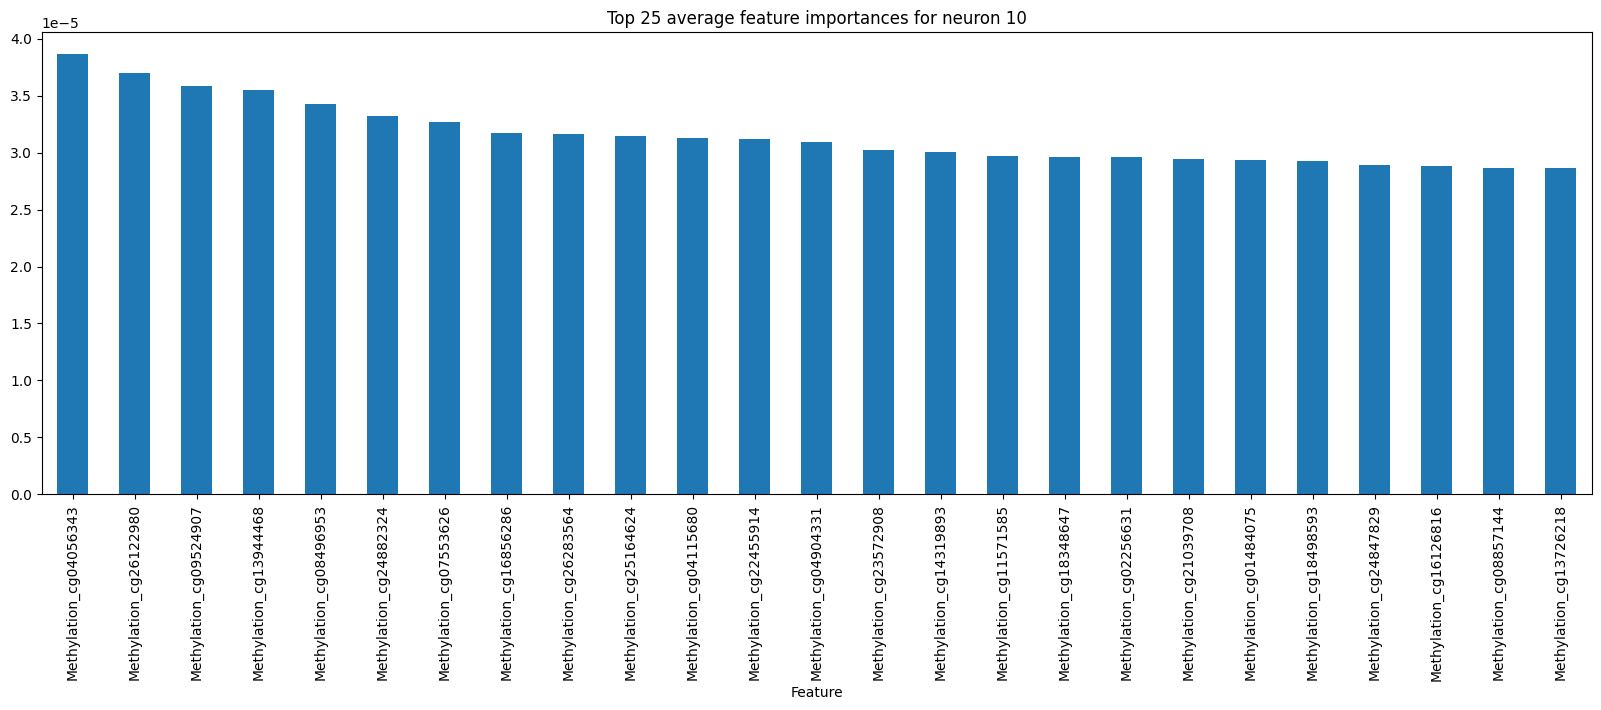

In [530]:
neuron_selector = sorted_neurons[0]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 25, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

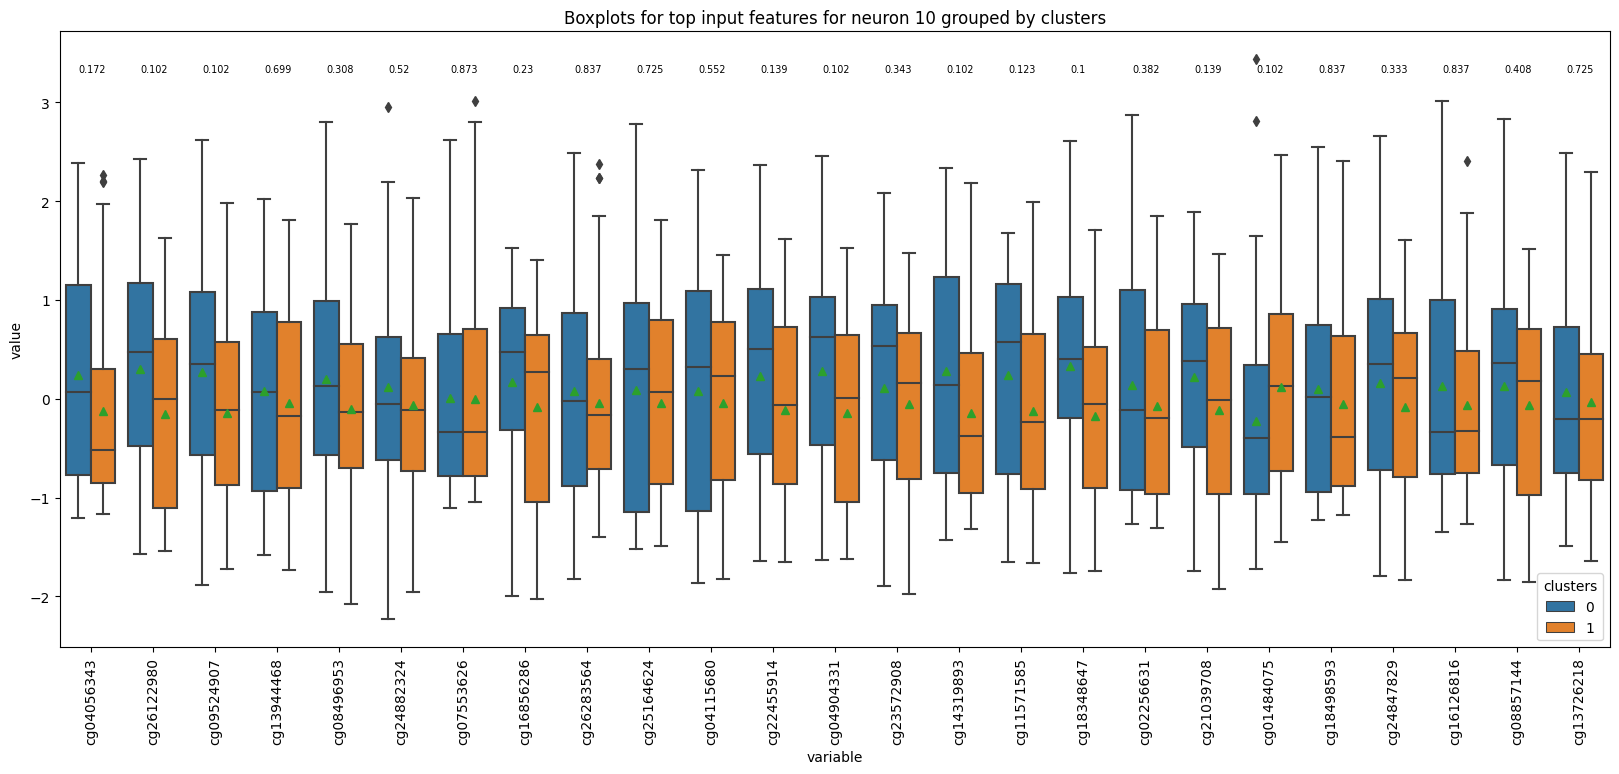

In [531]:
importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
most_important_features = features.to_frame("feature")
most_important_features["importance"] = importances
most_important_features = most_important_features.sort_values("importance", ascending= False).iloc[:25]
most_important_features = most_important_features.set_index("feature")
df = pd.concat(transformed_Xs, axis= 1)
most_important_features = [i.split("_")[-1] for i in most_important_features.index.to_list()]
df = df[most_important_features]
df["clusters"] = clusters

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters'), x="variable", y="value", hue="clusters", showmeans= True)
ax.set_title(f"Boxplots for top input features for neuron {neuron_selector} grouped by clusters")
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "clusters", loc= "lower right")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, 3.3, pvals[xtick], size='x-small', color= c.iloc[xtick])

In [532]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

Accuracy score = 0.66


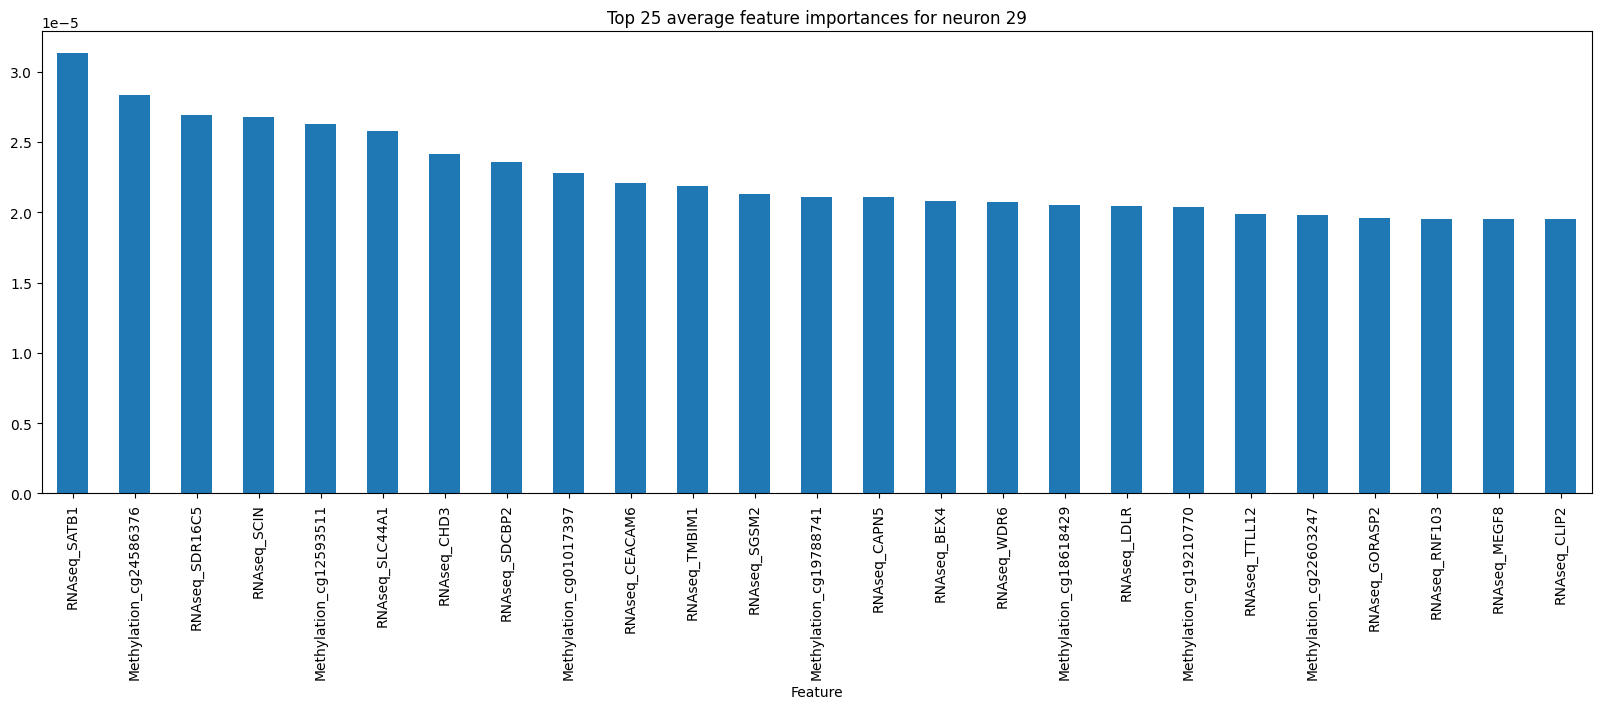

In [533]:
neuron_selector = sorted_neurons[1]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 25, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

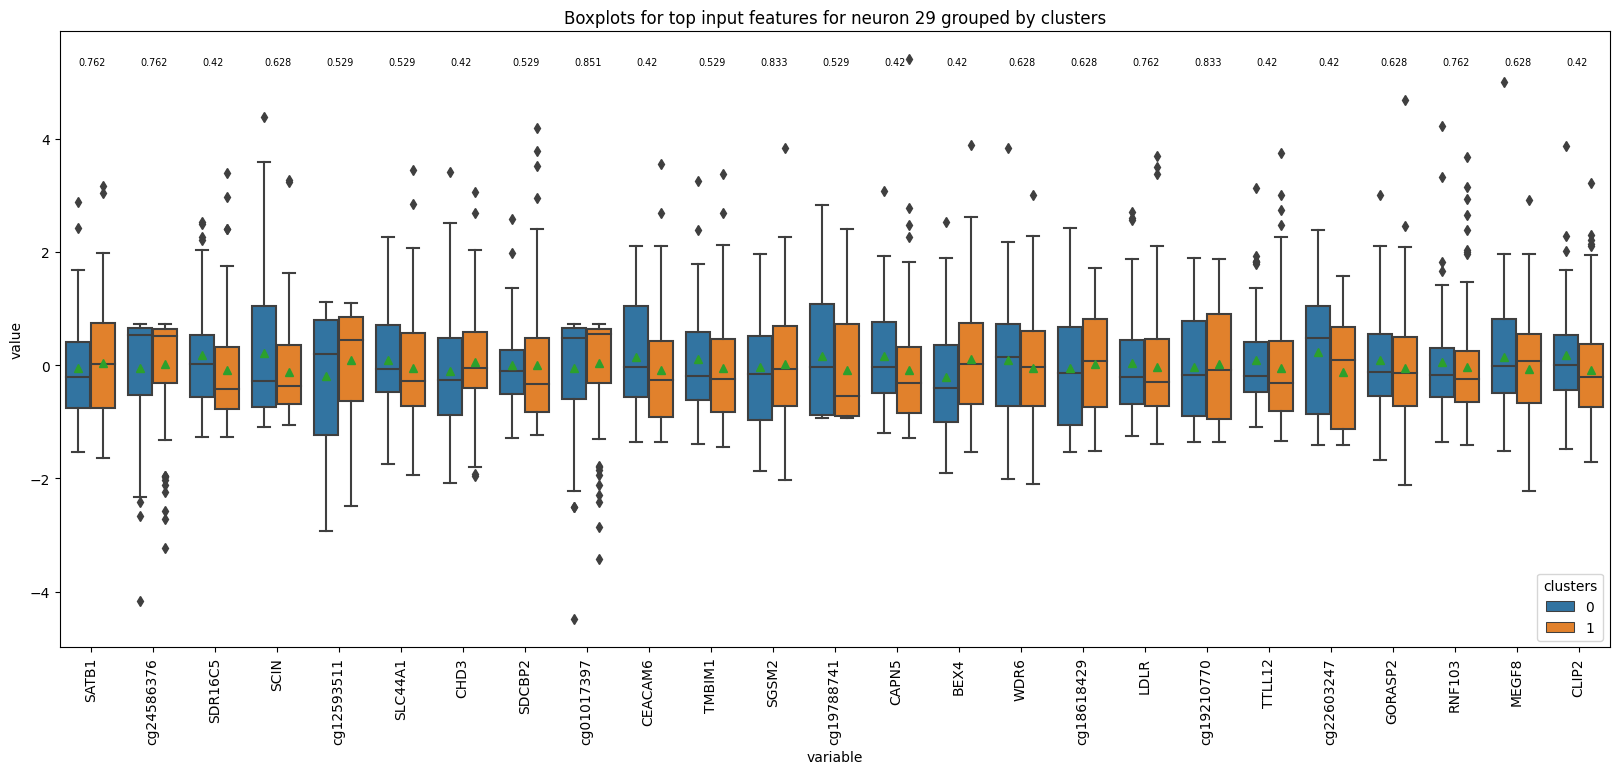

In [534]:
importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
most_important_features = features.to_frame("feature")
most_important_features["importance"] = importances
most_important_features = most_important_features.sort_values("importance", ascending= False).iloc[:25]
most_important_features = most_important_features.set_index("feature")
df = pd.concat(transformed_Xs, axis= 1)
most_important_features = [i.split("_")[-1] for i in most_important_features.index.to_list()]
df = df[most_important_features]
df["clusters"] = clusters

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters'), x="variable", y="value", hue="clusters", showmeans= True)
ax.set_title(f"Boxplots for top input features for neuron {neuron_selector} grouped by clusters")
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "clusters", loc= "lower right")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, 5.3, pvals[xtick], size='x-small', color= c.iloc[xtick])

In [535]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

Accuracy score = 0.64


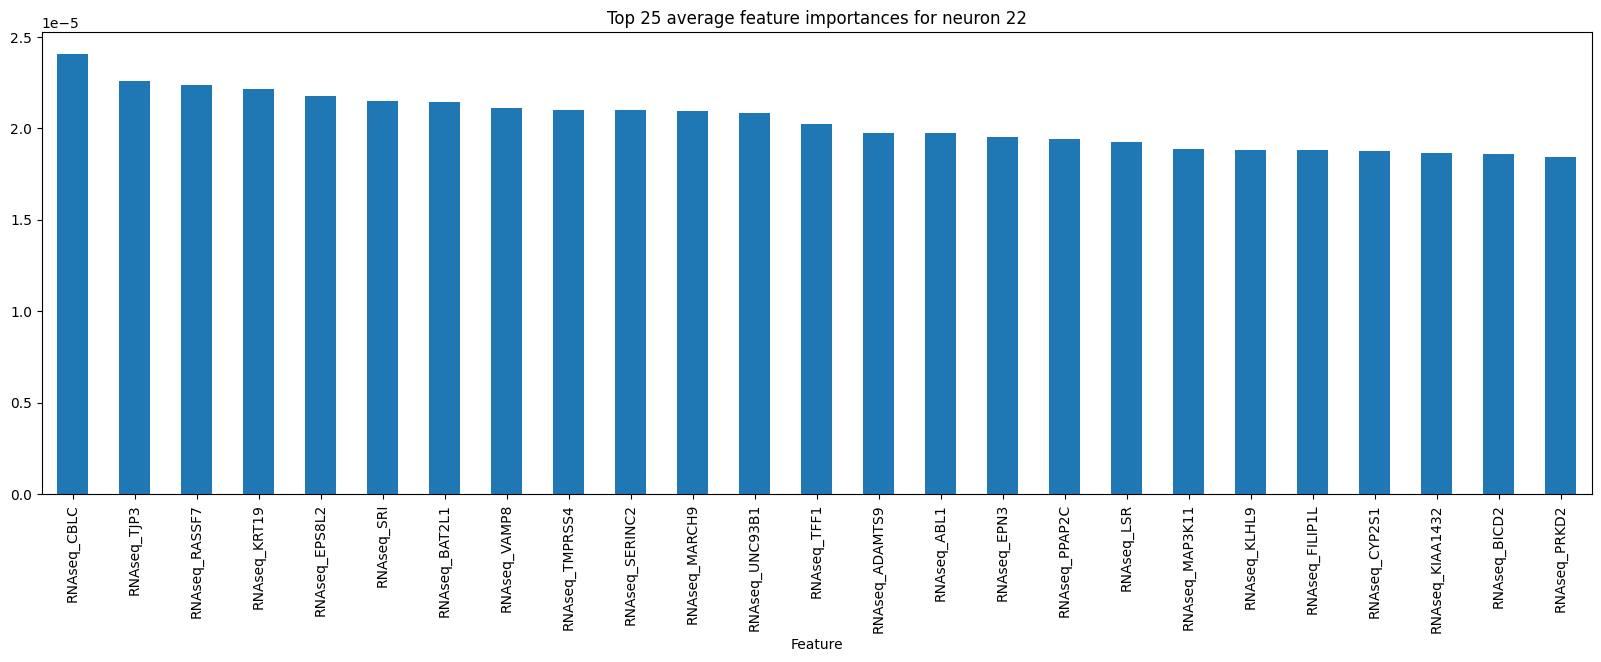

In [536]:
neuron_selector = sorted_neurons[2]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 25, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

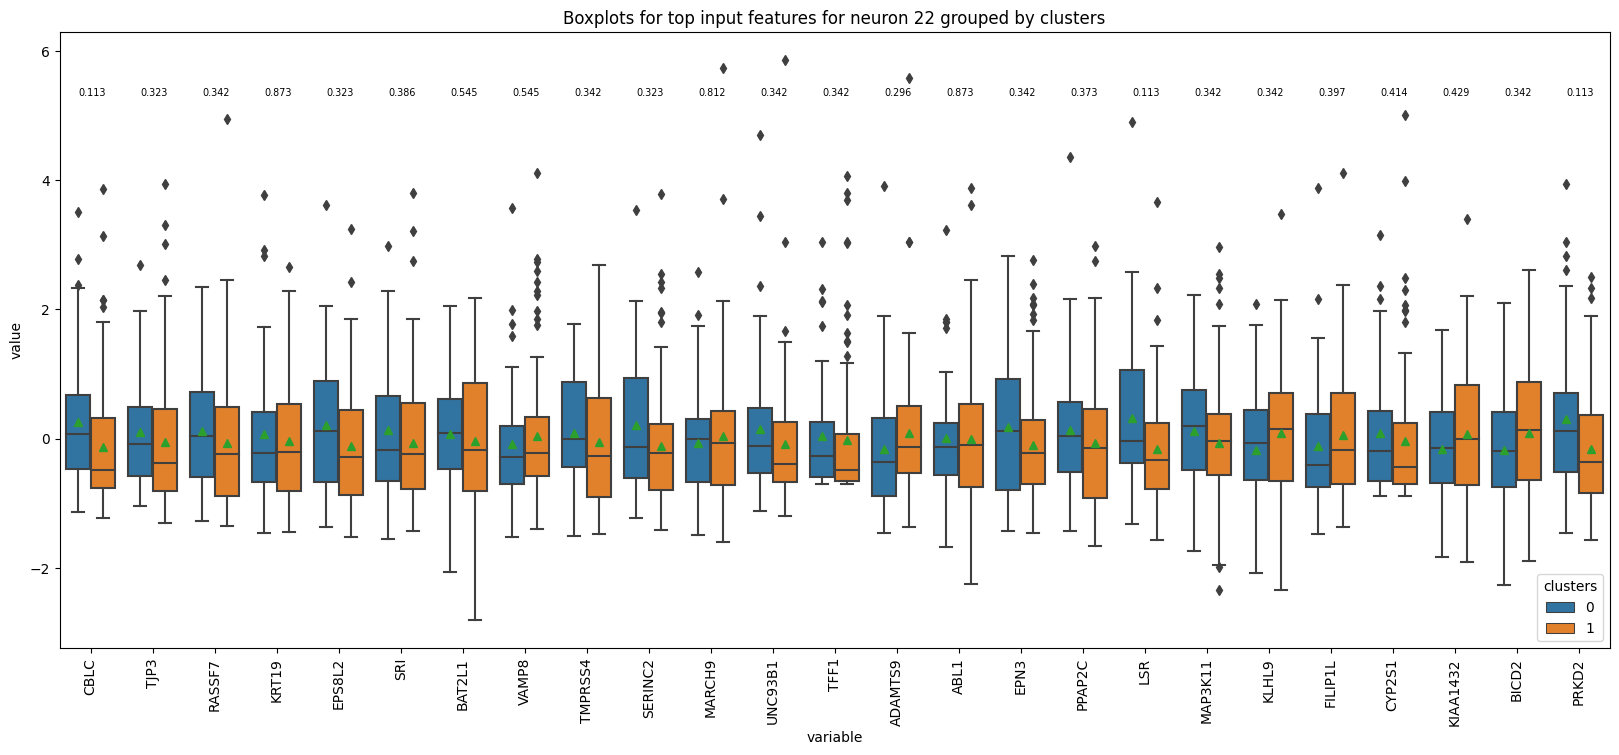

In [537]:
importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
most_important_features = features.to_frame("feature")
most_important_features["importance"] = importances
most_important_features = most_important_features.sort_values("importance", ascending= False).iloc[:25]
most_important_features = most_important_features.set_index("feature")
df = pd.concat(transformed_Xs, axis= 1)
most_important_features = [i.split("_")[-1] for i in most_important_features.index.to_list()]
df = df[most_important_features]
df["clusters"] = clusters

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters'), x="variable", y="value", hue="clusters", showmeans= True)
ax.set_title(f"Boxplots for top input features for neuron {neuron_selector} grouped by clusters")
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "clusters", loc= "lower right")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, 5.3, pvals[xtick], size='x-small', color= c.iloc[xtick])

In [538]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

Accuracy score = 0.67
